In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

base_dir = "C:/Users/Xin/Onedrive - Drexel University/BrainImaging_ML/"
# base_dir = "/home/xin/Dropbox/BrainImaging_ML/"
data_dir = base_dir + "data"

input_dir = "out03_age_prediction_hc2_stdz_age_reverse_notract_fa_scale_thresh.09"
output_dir = "out04_fit_brain_age_disorder_hc2_stdz_age_reverse_notract_fa_scale_thresh.09"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

model = 'cluster_gmmEEE4'
#model = 'cluster_km4'

method = 'ridge'
# method = 'svrlinear'


# select a more strict criterion for HCs:
hc_column = 'mental_hc2'

## Healthy control:
scatter_data_hc = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_" + model + ".csv", 
                              sep = ",", header = 0, index_col=0)
scatter_data_hc['group'] = 'HC'
scatter_data_hc['Sex'] = (scatter_data_hc['Sex']+1)/2
scatter_data_hc['Sex'].astype('int32')

# select mental healthy subjects:
behav_data = pd.read_csv(data_dir+"/pyresult01_pnc_behav_mental4.csv", delimiter = ",")
behav_data = behav_data.astype({'SUBJID': 'int64'})
behav_data["Med_Rating"] = behav_data["Med_Rating"].apply(pd.to_numeric, errors='coerce')
behav_data = behav_data.loc[behav_data["Med_Rating"]<2,:]

behav_data_hc = behav_data.loc[behav_data[hc_column]==True, 'SUBJID']

## select a subset of strict HCs:
scatter_data_hc = scatter_data_hc.loc[scatter_data_hc['SUBJID'].isin(behav_data_hc),:]

## disorder groups:
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_disorder_" + model + ".csv", 
                           sep = ",", header = 0, index_col=0)

## combine hc and disorder groups:
scatter_data = pd.concat([scatter_data_hc, scatter_data])
scatter_data["cluster"].apply(pd.to_numeric, errors='coerce')
# scatter_data['cluster'].astype('int32')

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

# scatter_data.set_index('cluster', inplace = True)
# scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str') 
scatter_data['group'].unique()

array(['HC', 'smry_ptd', 'smry_dep', 'smry_phb', 'smry_soc', 'smry_add',
       'smry_odd'], dtype=object)

In [2]:
scatter_data_hc

cluster        SUBJID  CV  chronological age  brain age  Sex group
0      4.0  600009963128   1                9.0  11.089263  0.0    HC
1      4.0  600110937794   1               10.0   9.214716  0.0    HC
2      4.0  600409285352   1               16.0  17.638347  1.0    HC
3      4.0  600647003585   1               18.0  16.592412  0.0    HC
4      4.0  600883641613   1               19.0  17.213890  1.0    HC
..     ...           ...  ..                ...        ...  ...   ...
50     all  608993118659   3               19.0  15.949675  0.0    HC
51     all  609072841451   3               18.0  15.445371  0.0    HC
52     all  609485506588   3               20.0  16.179270  0.0    HC
53     all  609575311394   3               12.0  14.591518  1.0    HC
54     all  609802779962   3               16.0  16.083315  0.0    HC

[830 rows x 7 columns]

In [3]:


scatter_data['cluster'].unique()

array(['4.0', '3.0', '2.0', '1.0', 'all'], dtype=object)

In [4]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data['cluster'].unique()
group_list = scatter_data['group'].unique()

regr = linear_model.LinearRegression()

for icluster in cluster_list:
#     for igroup in group_list[1:]:

    row_index_hc = (scatter_data['cluster']==icluster)&(scatter_data['group']=='HC')
    row_index = (scatter_data['cluster']==icluster)
    
    scatter_data_cluster = scatter_data.loc[row_index_hc,:]
    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the test set
    scatter_data_cluster = scatter_data.loc[row_index,:]
    X_test = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                        np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))
    
    X_test = np.hstack((X_test,
                         np.vstack((X_test[:,0]*X_test[:,1])), 
                         np.vstack((X_test[:,0]*X_test[:,2]))))
    
    y_pred = regr.predict(X_test)

    scatter_data.loc[row_index, 'brain age fit intersex'] = y_pred

#scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)
scatter_data.replace({'Sex': {0: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(input_dir+"/out04_scatter_data_" + method + "_" + model +"_fit_brain_age.csv")


In [5]:
scatter_data['group'] = scatter_data['group'].map({'HC': 'HC',
                                                   'smry_phb': 'Specific Phobia', 
                                                   'smry_soc': 'Social Phobia',
                                                   'smry_dep': 'Depression',
                                                   'smry_ptd': 'PTSD',
                                                   'smry_odd': 'ODD',
                                                   'smry_add': 'ADHD'})

# scatter_data

In [6]:
# correction for Kmeans:

# scatter_data['cluster'] = scatter_data['cluster'].map({'1': '1.0',
#                                                        '2': '2.0',
#                                                        '3': '3.0',
#                                                        'all': 'all',
#                                                       })

In [7]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster']=='1.0',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific Phobia', 
                                                                'Social Phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

demo_summary = scatter_data.loc[scatter_data['cluster']=='1.0', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary

group  sample size  females  age (mean)  age (std)
0               HC          166       82   14.506024   3.794329
1  Specific Phobia          185      120   13.600000   3.191701
2    Social Phobia          142       82   14.457746   2.829989
3       Depression           70       47   16.000000   2.407717
4             PTSD           71       51   15.507042   2.724876
5              ODD          206      112   14.359223   2.519599
6             ADHD          106       51   13.377358   2.983934

In [8]:
# remove subjects with comobidity (with more than one disorder):
# comorbity subject were just removed from the larger disorder group.
scatter_data['group2'] = scatter_data['group'].map({'HC': 'aHC',
                                                   'Specific Phobia': 'fSpecific Phobia', 
                                                   'Social Phobia': 'eSocial Phobia',
                                                   'Depression': 'bDepression',
                                                   'PTSD': 'cPTSD',
                                                   'ODD': 'gODD',
                                                   'ADHD': 'dADHD'})


scatter_data = scatter_data.sort_values(by = ['group2'], ascending = True)
scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep='first')
# scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep=False)


scatter_data['cluster2'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
                                                       '5.0': 'cluster 5',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster2'] = pd.Categorical(scatter_data['cluster2'], ordered=True, categories=column_title)
# cat_type = CategoricalDtype(categories=column_title, ordered=True)
# scatter_data['cluster2'] = scatter_data['cluster2'].astype(cat_type)

# cat_type = CategoricalDtype(categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'], 
#                             ordered=True)
# scatter_data['group2'] = scatter_data['group'].astype(cat_type)

scatter_data['group2'] = pd.Categorical(scatter_data['group'], ordered=True,
                                        categories=['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
# scatter_data

In [9]:
scatter_data['group2'].unique().sort_values()

[HC, Specific Phobia, Social Phobia, Depression, PTSD, ODD, ADHD]
Categories (7, object): [HC < Specific Phobia < Social Phobia < Depression < PTSD < ODD < ADHD]

In [10]:
column_title

['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster all']

In [11]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster2']=='cluster 1',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific Phobia', 
                                                                'Social Phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

group
HC                 82
Specific Phobia    46
Social Phobia      43
Depression         47
PTSD               31
ODD                20
ADHD               37
Name: (chronological age, count), dtype: int64

In [12]:
demo_summary = scatter_data.loc[scatter_data['cluster2']=='cluster 1', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary.to_csv(input_dir+"/out04_demo_summary.csv")
demo_summary

group  sample size  females  age (mean)  age (std)
0               HC          166       82   14.506024   3.794329
1  Specific Phobia           70       46   12.571429   3.169471
2    Social Phobia           77       43   14.051948   2.851113
3       Depression           70       47   16.000000   2.407717
4             PTSD           44       31   15.159091   2.836172
5              ODD           48       20   14.562500   2.657036
6             ADHD           81       37   13.086420   2.967312

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

def qudratic_r_squared_gender(chro_age, brain_age, gender):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age and gender.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c, d, e, f):
        x1, x2 = x
        #return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 f*(x1**2)*x2
        return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 + f*(x1**2)*x2
    
    popt, pcov = curve_fit(qudratic_fun, (chro_age, gender), brain_age)
    brain_age_pred = qudratic_fun((chro_age, gender), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

In [14]:
scatter_data

index cluster        SUBJID   CV  chronological age  brain age Sex  \
0         0     4.0  600009963128  1.0                9.0  11.089263   F   
547      49     1.0  609173350200  1.0               12.0  10.826562   M   
548      50     1.0  609259470422  1.0               10.0  12.920209   F   
549      51     1.0  609262364081  1.0               13.0  14.868029   F   
550      52     1.0  609652761759  1.0               19.0  16.676359   F   
...     ...     ...           ...  ...                ...        ...  ..   
3098    618     3.0  606855754171  NaN               16.0  17.407694   M   
3092    593     3.0  606673058004  NaN               17.0  15.863007   M   
3090    587     3.0  606531042603  NaN               17.0  15.635702   F   
3087    573     3.0  606304691757  NaN               21.0  14.800285   M   
3081    546     3.0  606109358844  NaN               14.0  15.912324   M   

     group  brain age fit intersex   age gap  age gap corr group2   cluster2  
0       HC               11.309762  2.089263     -0.220499     HC  cluster 4  
547     HC               13.524416 -1.173438     -2.697854     HC  cluster 1  
548     HC               12.596638  2.920209      0.323571     HC  cluster 1  
549     HC               13.961742  1.868029      0.906287     HC  cluster 1  
550     HC               16.236287 -2.323641      0.440072     HC  cluster 1  
...    ...                     ...       ...           ...    ...        ...  
3098   ODD               14.930017  1.407694      2.477677    ODD  cluster 3  
3092   ODD               15.260008 -1.136993      0.602999    ODD  cluster 3  
3090   ODD               15.774364 -1.364298     -0.138662    ODD  cluster 3  
3087   ODD               16.457940 -6.199715     -1.657654    ODD  cluster 3  
3081   ODD               14.233427  1.912324      1.678897    ODD  cluster 3  

[2780 rows x 13 columns]

In [15]:
# compute std of BAG for each cluster * group:
bag_std = scatter_data.groupby(['cluster', 'group']).std().loc[:, ['age gap corr']]
bag_std.reset_index(inplace = True)
bag_std_wide = bag_std.pivot(index='group', columns='cluster', values='age gap corr')
bag_std_wide

cluster               1.0       2.0       3.0       4.0       all
group                                                            
ADHD             2.124356  1.635077  1.795093  1.570588  1.608155
Depression       1.827941  1.444185  1.374111  1.548233  1.515821
HC               1.863887  1.596672  1.862842  1.733418  1.675287
ODD              1.804856  1.547155  1.745163  1.405667  1.430894
PTSD             1.936628  1.744317  1.763696  1.645145  1.700510
Social Phobia    2.002576  1.498234  1.932426  1.656890  1.750165
Specific Phobia  1.986877  1.500934  1.804723  1.647365  1.699799

In [16]:
# compute std of BAG for each cluster * group:
bag_m = scatter_data.groupby(['cluster', 'group']).mean().loc[:, ['age gap corr']]
bag_m.reset_index(inplace = True)
bag_m_wide = bag_m.pivot(index='group', columns='cluster', values='age gap corr')
bag_m_wide

cluster                   1.0           2.0           3.0           4.0  \
group                                                                     
ADHD            -1.426705e-01 -6.616798e-02 -8.109169e-02  1.472585e-01   
Depression       1.931251e-01 -7.716960e-02  2.638115e-01  1.164935e-01   
HC               1.391123e-15  3.745331e-16  1.187805e-15 -1.037992e-15   
ODD              5.969129e-01  2.703734e-01  6.758735e-01  7.173475e-01   
PTSD             2.658134e-01  1.607680e-01  1.310718e-01  2.919656e-01   
Social Phobia   -9.331449e-02 -5.395824e-02  4.672811e-02  4.061196e-02   
Specific Phobia -7.927324e-01 -4.352541e-01 -5.638373e-01 -3.794361e-01   

cluster                   all  
group                          
ADHD            -8.557993e-02  
Depression      -9.156530e-02  
HC               1.530235e-15  
ODD              4.869684e-01  
PTSD             2.314289e-01  
Social Phobia   -1.558151e-01  
Specific Phobia -5.687346e-01

In [17]:
import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM
import pingouin as pg

scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster2']!='cluster all',:]
scatter_data2['cluster2'] = scatter_data2['cluster2'].cat.remove_unused_categories()

# save data to allow analysis with R packages:
scatter_data2.to_csv(output_dir+'/out04_scatter_data.csv', index = False)


cluster_idx = scatter_data2['cluster2'].unique().sort_values()
num_cluster = len(cluster_idx)

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster']!='all',:]

# model = ols('BAG ~ C(group)*C(cluster)', scatter_data2).fit()
# model.summary()

# aovrm2way = AnovaRM(scatter_data2, 'BAG', 'SUBJID', between = ['group'], within=['cluster'])
# res2way = aovrm2way.fit()
# print(res2way)

aov = pg.mixed_anova(data=scatter_data2, dv='BAG', between='group', within='cluster',
                     subject='SUBJID', correction='auto' )
pg.print_table(aov)

# aov = pg.mixed_anova(data=scatter_data2, dv='age gap', between='group', within='cluster',
#                      subject='SUBJID', correction='auto' )
# pg.print_table(aov)



ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc  p-GG-corr              np2  eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  -------------------  -----  -----  ------------  ---------  ----------------------
group        191.579      6    549  31.930  2.936    0.008  -                    0.031  -      -             -          -
cluster        7.399      4   2196   1.850  1.913    0.106  0.12459707088523117  0.003  0.756  False         0.425      3.0443111264994603e-96
Interaction   20.227     24   2196   0.843  0.871    0.644  -                    0.009  -      -             -          -



C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [18]:
scatter_data2['cluster'].unique()

array(['4.0', '1.0', '2.0', 'all', '3.0'], dtype=object)

In [19]:
#library(permuco)
#aovperm(nMVPA_42 ~ Cond , data = data )

report = pd.DataFrame(columns = ['disorder', 'p value(group)', 'p value(cluster)', 'p value(interaction)']) 
group_label = list(scatter_data2['group2'].unique().sort_values())
# group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
report['disorder'] = group_label[1:]

i=0
for dis in group_label[1:]:
    print(dis)
    
    scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
    aov = pg.mixed_anova(data=scatter_data_dis, dv='BAG', between='group', within='cluster',
                         subject='SUBJID', correction='auto')
    
    report.iloc[i,1:] = aov['p-unc'].values
    i+=1
    pg.print_table(aov)

Specific Phobia

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  ------------------  -----  -----  ------------  ---------  ---------------------
group        73.930      1    234  73.930  6.746    0.010  -                   0.028  -      -             -          -
cluster       2.112      4    936   0.528  0.494    0.740  0.6758079933282906  0.002  0.707  False         0.37       5.896629399309703e-45
Interaction   5.007      4    936   1.252  1.172    0.322  -                   0.005  -      -             -          -

Social Phobia

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc  p-GG-corr            np2  eps    sphericity    W-spher    p-spher
-----------  -----  -----  -----  -----  -----  -------  -----------------  -----  -----  ------------  ---------  ----------------------
group        0.490      1    2

In [20]:
# i=0
# for dis in group_label[1:]:
#     print(dis)
    
#     scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
#     aov = pg.mixed_anova(data=scatter_data_dis, dv='age gap', between='group', within='cluster',
#                          subject='SUBJID', correction='auto')
    
#     report.iloc[i,1:] = aov['p-unc'].values
#     i+=1
#     pg.print_table(aov)

In [21]:
pd.options.display.float_format = '{:,.5f}'.format

report2 = report.copy()
report2.iloc[:, 1:] = report2.iloc[:, 1:].astype(float).round(3)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report2.iloc[:,1:].le(2)] = report2[
    report2.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

report2[report.iloc[:,1:].le(0.05)] = report2[
    report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report.iloc[:,1:].le(0.01)] = report2[
    report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

report2[report.iloc[:,1:].le(0.001)] = report2[
    report.iloc[:,1:].le(0.001)].astype(str).apply(lambda x : x.str[:5]).add('***')
report

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia        0.00999          0.74008              0.32179
1    Social Phobia        0.83588          0.94732              0.81352
2       Depression        0.69253          0.71784              0.29110
3             PTSD        0.39808          0.99652              0.95716
4              ODD        0.02304          0.84804              0.31318
5             ADHD        0.82276          0.86163              0.61574

In [22]:
report2.to_csv(output_dir+'/out03_anova_disorder_table' + method + '_' + model + '.csv')
report2

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia        0.010**            0.740                0.322
1    Social Phobia          0.836            0.947                0.814
2       Depression          0.693            0.718                0.291
3             PTSD          0.398            0.997                0.957
4              ODD         0.023*            0.848                0.313
5             ADHD          0.823            0.862                0.616

In [23]:
from statsmodels.stats.multitest import multipletests

report_corrected = report.copy()

# correction_method = 'hommel'
correction_method = 'fdr_bh'
# correction_method = 'holm'

num_col = report.shape[1]
for i in range(1, num_col):
    output = multipletests(report_corrected.iloc[:,i], alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
    report_corrected.iloc[:, i] = output[1]


report2 = report_corrected.copy()
report2.iloc[:, 1:] = report2.iloc[:, 1:].astype(float).round(3)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report2.iloc[:,1:].le(2)] = report2[
    report2.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

report2[report_corrected.iloc[:,1:].le(0.05)] = report2[
    report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report_corrected.iloc[:,1:].le(0.01)] = report2[
    report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')


report2.to_csv(output_dir+'/out03_anova_disorder_table' + method + '_' + model + '_' + correction_method + '.csv')
report2

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia          0.060            0.997                0.644
1    Social Phobia          0.836            0.997                0.957
2       Depression          0.836            0.997                0.644
3             PTSD          0.796            0.997                0.957
4              ODD          0.069            0.997                0.644
5             ADHD          0.836            0.997                0.924

In [24]:
column_title = scatter_data2['cluster2'].unique().sort_values()
group_label = list(scatter_data2['group2'].unique().sort_values())

report_col =['disorder'] + ['p value(' + i +')' for i in column_title]
permutation_report = pd.DataFrame(columns = report_col) 
permutation_report['disorder'] = group_label[1:]
permutation_report

disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia                NaN                NaN                NaN   
1    Social Phobia                NaN                NaN                NaN   
2       Depression                NaN                NaN                NaN   
3             PTSD                NaN                NaN                NaN   
4              ODD                NaN                NaN                NaN   
5             ADHD                NaN                NaN                NaN   

  p value(cluster 4) p value(cluster all)  
0                NaN                  NaN  
1                NaN                  NaN  
2                NaN                  NaN  
3                NaN                  NaN  
4                NaN                  NaN  
5                NaN                  NaN

In [25]:
report_col = pd.MultiIndex.from_tuples([(i , j) for i in column_title for j in ["Cohen's d", 'p value']])
permutation_report_full = pd.DataFrame(index = group_label[1:], columns = report_col) 
permutation_report_full

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia       NaN     NaN       NaN     NaN       NaN     NaN   
Social Phobia         NaN     NaN       NaN     NaN       NaN     NaN   
Depression            NaN     NaN       NaN     NaN       NaN     NaN   
PTSD                  NaN     NaN       NaN     NaN       NaN     NaN   
ODD                   NaN     NaN       NaN     NaN       NaN     NaN   
ADHD                  NaN     NaN       NaN     NaN       NaN     NaN   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia       NaN     NaN         NaN     NaN  
Social Phobia         NaN     NaN         NaN     NaN  
Depression            NaN     NaN         NaN     NaN  
PTSD                  NaN     NaN         NaN     NaN  
ODD                   NaN     NaN         NaN     NaN  
ADHD                  NaN     NaN         NaN     NaN

In [26]:
pd.options.display.float_format = '{:,.5f}'.format
# permutation test:
from mlxtend.evaluate import permutation_test

i=0
for dis in group_label[1:]:
    print(dis)
    p_dis = []
    for icluster in column_title:
        bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'BAG']
#         bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'age gap']
        ibag_hc =  scatter_data2.loc[(scatter_data2['group']=='HC')&(scatter_data2['cluster2']==icluster), 'BAG']
    
        p_dis1 = permutation_test(ibag_hc, bag_dis1, method='approximate', num_rounds=10000, seed=0)
        p_dis.append(p_dis1)
        
        m_dis1 = np.mean(ibag_hc) - np.mean(bag_dis1)
        eta = -m_dis1/np.sqrt((np.std(ibag_hc)**2 + np.std(bag_dis1)**2)/2)
        
        permutation_report_full.loc[dis, (icluster, 'p value')] = p_dis1
        permutation_report_full.loc[dis, (icluster, "Cohen's d")] = eta

    permutation_report.iloc[i,1:] = p_dis
    i+=1

print(permutation_report)


Specific Phobia
Social Phobia
Depression
PTSD
ODD
ADHD
          disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia            0.00440            0.05010            0.03420   
1    Social Phobia            0.72410            0.80570            0.85660   
2       Depression            0.46210            0.73740            0.28580   
3             PTSD            0.41270            0.55660            0.67740   
4              ODD            0.05000            0.29780            0.02670   
5             ADHD            0.59020            0.75580            0.73730   

  p value(cluster 4) p value(cluster all)  
0            0.12180              0.01990  
1            0.86540              0.50180  
2            0.62650              0.70200  
3            0.32610              0.42540  
4            0.00720              0.06530  
5            0.52170              0.70750  


In [27]:
# permutation_report_full.loc[:, (slice(None), 'diff')]
permutation_report_full

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia  -0.41368 0.00440  -0.28229 0.05010  -0.30899 0.03420   
Social Phobia    -0.04847 0.72410  -0.03501 0.80570   0.02474 0.85660   
Depression        0.10515 0.46210  -0.05094 0.73740   0.16190 0.28580   
PTSD              0.14090 0.41270   0.09688 0.55660   0.07277 0.67740   
ODD               0.32753 0.05000   0.17313 0.29780   0.37690 0.02670   
ADHD             -0.07174 0.59020  -0.04114 0.75580  -0.04453 0.73730   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia  -0.22552 0.12180    -0.33874 0.01990  
Social Phobia     0.02406 0.86540    -0.09140 0.50180  
Depression        0.07123 0.62650    -0.05760 0.70200  
PTSD              0.17399 0.32610     0.13811 0.42540  
ODD               0.45730 0.00720     0.31452 0.06530  
ADHD              0.08943 0.52170    -0.05235 0.70750

In [28]:


permutation_report2 = permutation_report.copy()
permutation_report2.iloc[:, 1:] = permutation_report2.iloc[:, 1:].astype(float).round(3)

# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

permutation_report2[permutation_report.iloc[:,1:].le(2)] = permutation_report2[
    permutation_report.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report2[permutation_report.iloc[:,1:].le(0.05)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report2[permutation_report.iloc[:,1:].le(0.01)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report2.to_csv(output_dir+'/out03_permutation_disorder_table' + method + '_' + model + '.csv')
permutation_report2

disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia            0.004**              0.050             0.034*   
1    Social Phobia              0.724              0.806              0.857   
2       Depression              0.462              0.737              0.286   
3             PTSD              0.413              0.557              0.677   
4              ODD             0.050*              0.298             0.027*   
5             ADHD              0.590              0.756              0.737   

  p value(cluster 4) p value(cluster all)  
0              0.122               0.020*  
1              0.865                0.502  
2              0.626                0.702  
3              0.326                0.425  
4            0.007**                0.065  
5              0.522                0.708

In [29]:
pd.options.display.float_format = '{:,.6f}'.format

permutation_report_full2 = permutation_report_full.copy()
permutation_report_full2 = permutation_report_full2.astype(float).round(3).astype(str)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

# convert numeric value to strings with 3 decimal digits:
permutation_report_full2[permutation_report_full.le(0)] = permutation_report_full2[
    permutation_report_full.le(0)].astype(str).apply(lambda x : x.str[:6]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.ge(0)] = permutation_report_full2[
    permutation_report_full.ge(0)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report_full2.to_csv(output_dir+'/out03_permutation_disorder_table_full_' + method + '_' + model + '.csv')
permutation_report_full2

cluster 1          cluster 2         cluster 3          \
                Cohen's d  p value Cohen's d p value Cohen's d p value   
Specific Phobia    -0.414  0.004**    -0.282   0.050    -0.309  0.034*   
Social Phobia      -0.048    0.724    -0.035   0.806     0.025   0.857   
Depression          0.105    0.462    -0.051   0.737     0.162   0.286   
PTSD                0.141    0.413     0.097   0.557     0.073   0.677   
ODD                 0.328   0.050*     0.173   0.298     0.377  0.027*   
ADHD               -0.072    0.590    -0.041   0.756    -0.045   0.737   

                cluster 4          cluster all          
                Cohen's d  p value   Cohen's d p value  
Specific Phobia    -0.226    0.122      -0.339  0.020*  
Social Phobia       0.024    0.865      -0.091   0.502  
Depression          0.071    0.626      -0.058   0.702  
PTSD                0.174    0.326       0.138   0.425  
ODD                 0.457  0.007**       0.315   0.065  
ADHD                0.089    0.522      -0.052   0.708

In [30]:

def box_plot(scatter_data, permutation_report, p_thresh = .07):
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(24, 9)}, font_scale = 2)

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})


    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)

    scatter_data_group = scatter_data2[scatter_data2['group'].isin(group_label)]
    scatter_data_group.to_csv(input_dir+'/out04_scatter_data_all.csv')

    f, (ax1) = plt.subplots(1, sharex=True)

    # x_order =  ['HC', 'smry_phb', 'smry_soc', 'smry_dep', 'smry_ptd', 'smry_odd', 'smry_add']

    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data_group, 
                  hue = 'group2', dodge=True, ax = ax1,
                 palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                 alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
                notch = True, ax = ax1)


    # sns.swarmplot(y = "age gap", x = "cluster2", data = scatter_data_group, 
    #               hue = 'group2', dodge=True, ax = ax1,
    #              palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
    #              alpha = .75)

    # sns.boxplot(y = "age gap", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
    #             notch = True, ax = ax1)

    ax1.set(xlabel='', ylabel='brain age gap corr')

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = plt.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'upper right', 
                   prop = {'size': 13}, title = '',bbox_to_anchor=(1.11, 0.7), ncol=1)

    # cluster_idx = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
#     cluster_idx = scatter_data2['cluster2'].unique().sort_values()
#     comparision_pairs = [((cluster, 'HC'), (cluster, disorder)) 
#                          for cluster in cluster_idx 
#                              for disorder in group_label[1:]]

    # add_stat_annotation(ax1, y = "age gap corr", x = "cluster", data = scatter_data, hue = 'group', 
    #                     box_pairs = comparision_pairs,
    #                     test='t-test_ind', 
    #                     comparisons_correction = 'bonferroni',
    # #                     comparisons_correction = None,
    #                     line_height=0.01, fontsize='small', color='0.2', linewidth=1, 
    #                     text_format='simple', loc='inside', verbose=2)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color)


    y_base = np.array([1]*num_cluster)*7.5

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    plt.tight_layout()
    plt.show()
    return(f)


# f = box_plot(scatter_data, permutation_report)    
# f.savefig(input_dir+'/figure4_boxplot_age_gap_' + method + '_disorder_'+model+'.png', dpi=300)

${p}$=0.004
${p}$=0.050
${p}$=0.034
${p}$=0.020
${p}$=0.050
${p}$=0.027
${p}$=0.007
${p}$=0.065


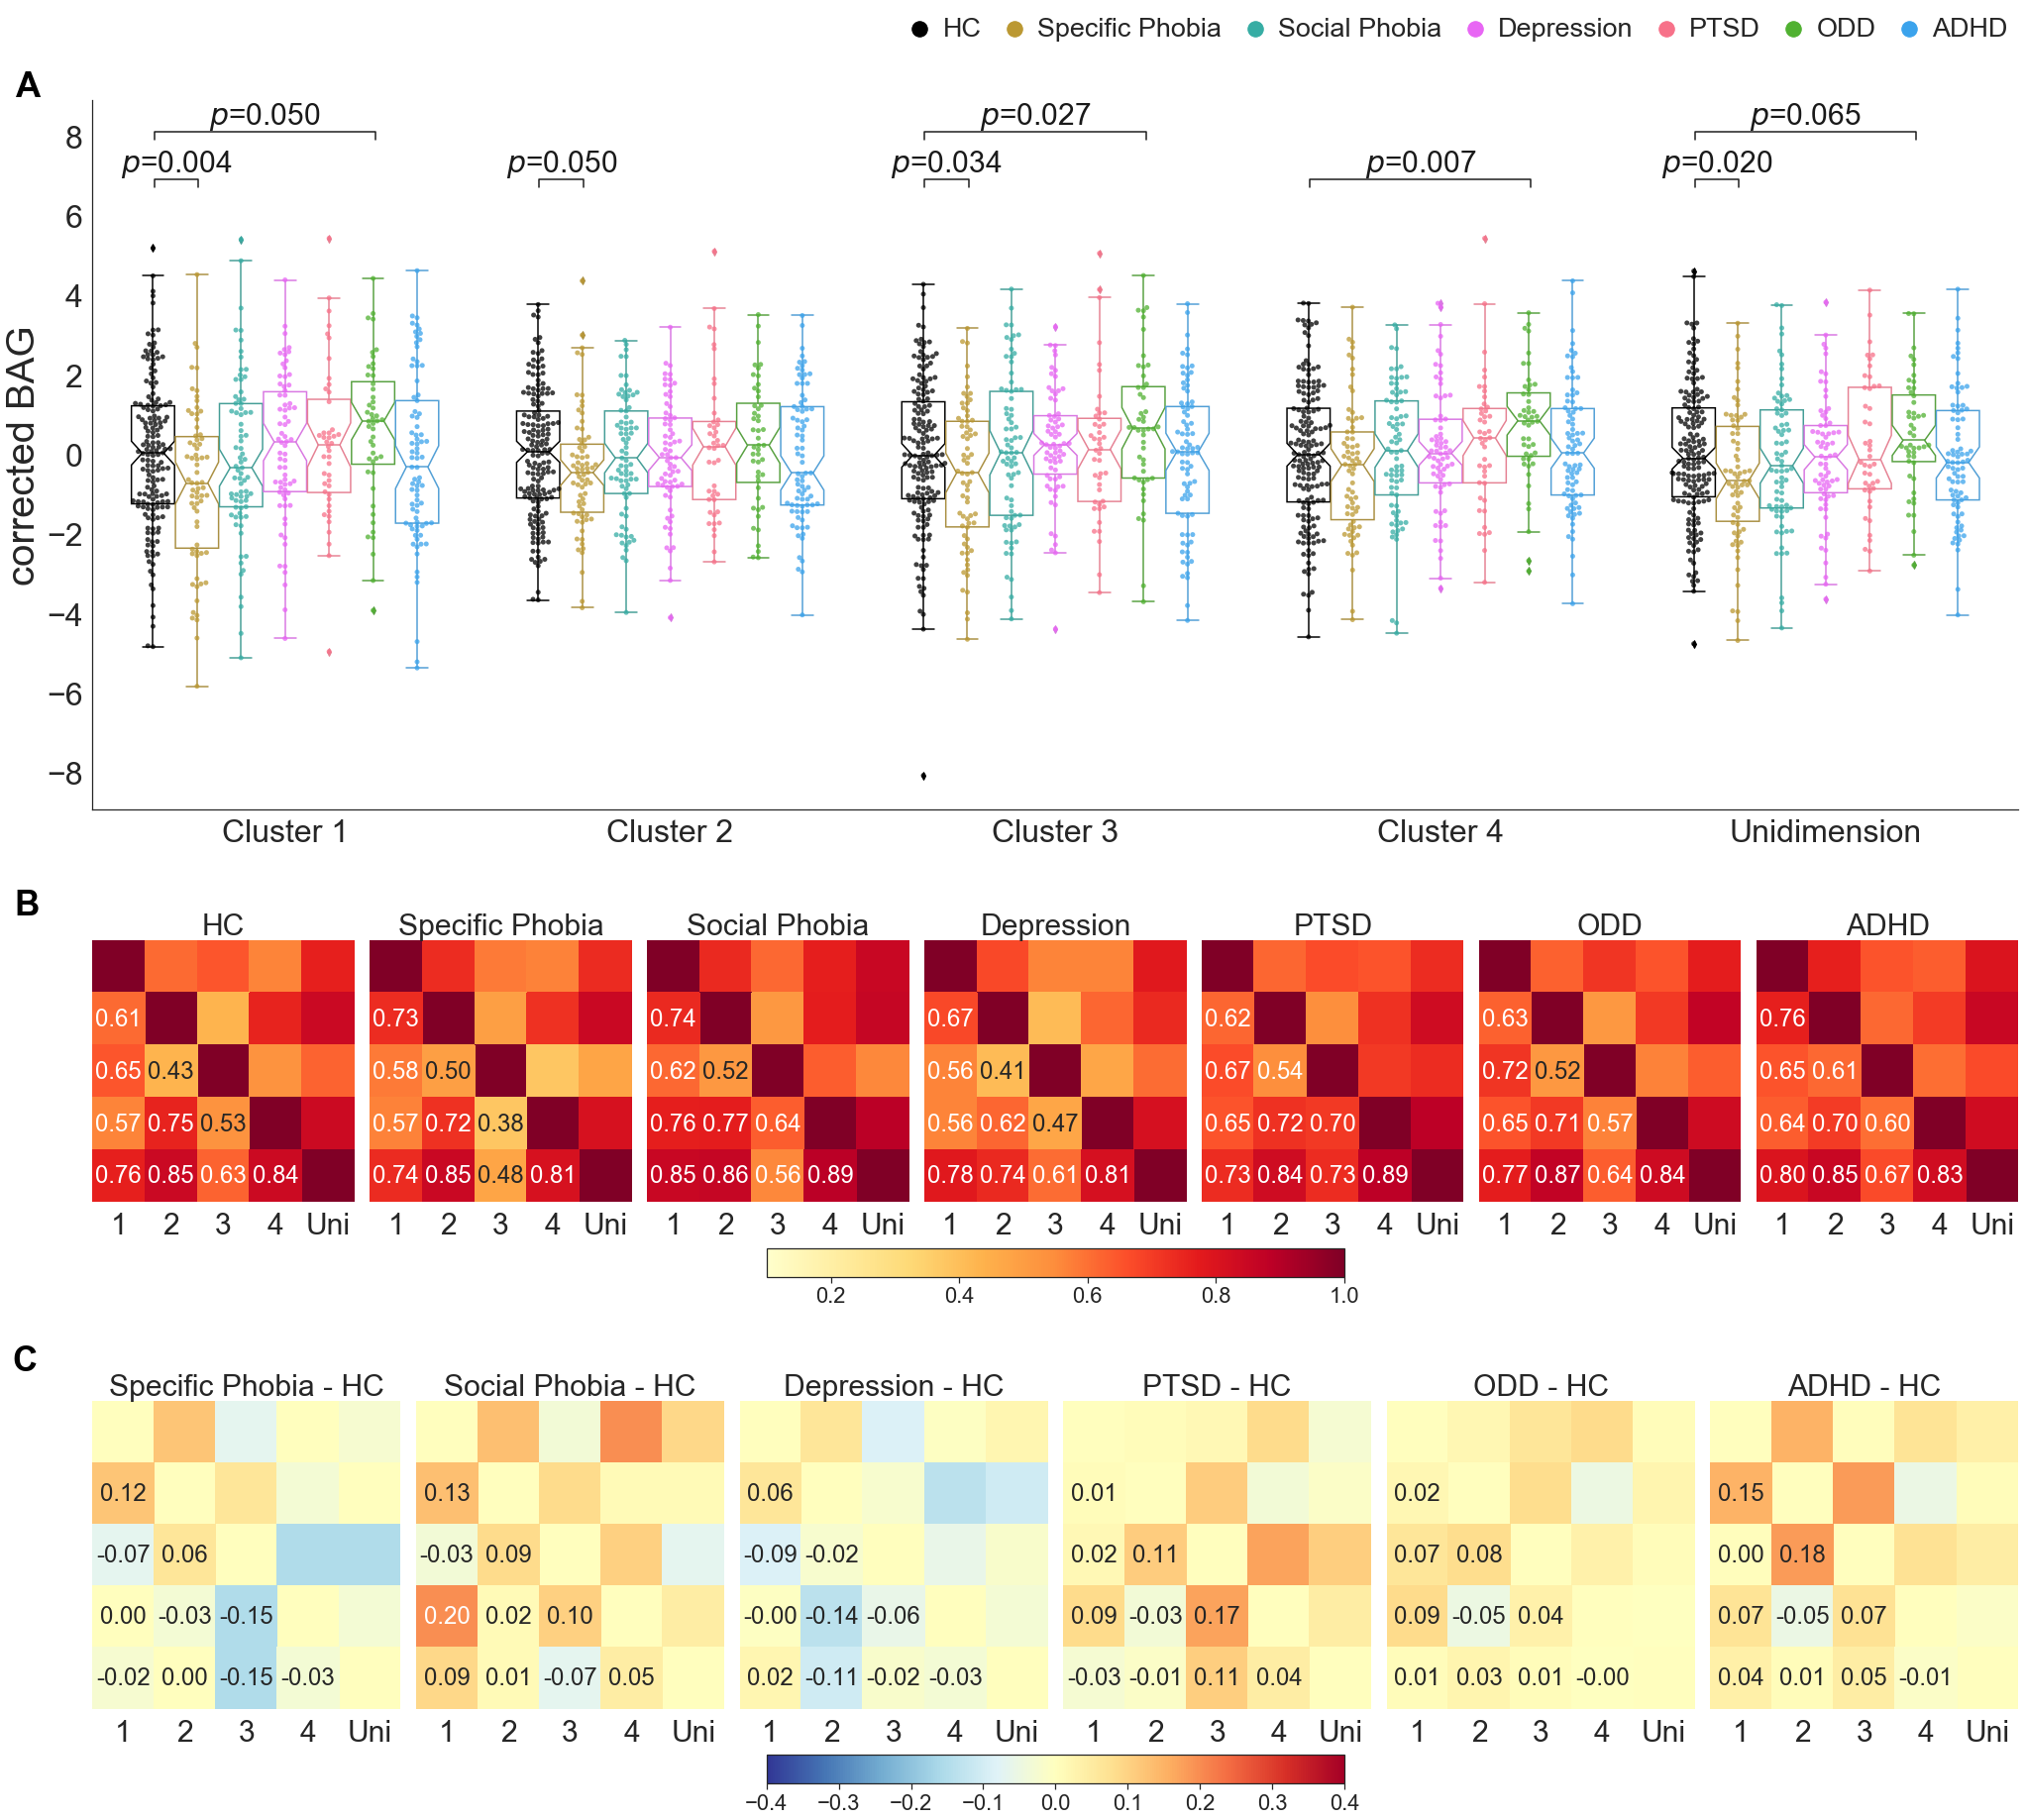

In [31]:
def box_heatmap_plot(scatter_data, permutation_report, p_thresh = .07):
    
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(30, 32)}, font_scale = 2)
    sns.set_style("white")

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)
    group_label = list(scatter_data['group2'].unique().sort_values())
    num_group = len(group_label)

    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=7, ncols=num_group*(num_group-1), left=0.05, right=0.95, wspace=0.5, hspace = .25)
    
    ax1 = fig.add_subplot(gs[0:3, :])
    
    ax2_list = []
    gs_coord1 = range(0, num_group*(num_group-1), num_group-1)
    gs_coord2 = range(num_group-1, num_group*(num_group-1)+1, num_group-1)
    for i_subplot in range(num_group):
        ax2_list.append(fig.add_subplot(gs[3:5, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))
        
    ax3_list = []  
    gs_coord1 = range(0, num_group*(num_group-1), num_group)
    gs_coord2 = range(num_group, num_group*(num_group-1)+1, num_group)
    for i_subplot in range(num_group-1):
        ax3_list.append(fig.add_subplot(gs[5:, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))

    ############ box plot: ###########################
    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data2, 
                  hue = 'group2', dodge=True, ax = ax1,
                  palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data2, hue = 'group2', palette = colors,
                notch = True, ax = ax1)

#     ax1.set(xlabel='', ylabel='BAG (with correction)')
    ax1.set_xlabel('')
    ax1.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Unidimension'])
    ax1.set_ylabel('corrected BAG', size = 40)
    ax1.tick_params(axis='x', labelsize=32)
    ax1.tick_params(axis='y', labelsize=32)
    #ax1.set_xticklabels(cluster_idx, size = 35)
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = ax1.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'right', columnspacing = 1.2,
                   frameon = False, markerscale =2, handlelength = .1,
                   prop = {'size': 27}, title = '', bbox_to_anchor=(1, 1.1), ncol=7)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color, size = 30)


    y_base = np.array([1]*num_cluster)*6.7

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    ax1.text(-.7, 9, "A", horizontalalignment='left', size=35, color='black', weight='bold')
    
    ############################# heat map #################################
    
    idx = 0
    idx2= 0
    for i_group in group_label:
        
        scatter_data_group = scatter_data2.loc[scatter_data2['group2']==i_group,['SUBJID', 'cluster2', 'BAG']]
        scatter_data_group = scatter_data_group.pivot(index='SUBJID', columns='cluster2', values='BAG')
        matrix = scatter_data_group.corr().values
        
        # partial correlation:
        scatter_data_sex = scatter_data2.loc[scatter_data2['group2']==i_group, ['SUBJID', 'Sex']]
        scatter_data_sex.replace({'Sex': {'F': 0, 'M': 1}}, inplace = True)
        cluster_col = scatter_data_group.columns.tolist()
        scatter_data_group.columns = cluster_col
        scatter_data_group.reset_index(inplace = True)
        scatter_data_group = scatter_data_group.merge(scatter_data_sex, how = 'left', on = 'SUBJID')
        scatter_data_group.set_index('SUBJID')
        for x in range(len(cluster_col)-1):
            for y in range(x+1, len(cluster_col)):
                pcor = scatter_data_group[[cluster_col[x], cluster_col[y], 'Sex']].pcorr()
                matrix[x,y] = pcor.values[0,1]
                matrix[y,x] = pcor.values[0,1]
        

        ## panel B:
        cmap_b = 'YlOrRd'
        # draw upper triangular heat map without annotation:
        im = sns.heatmap(matrix, annot=False, ax = ax2_list[idx], 
                         cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        # draw lower triangular heat map with annotation:
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        im = sns.heatmap(matrix, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                         ax = ax2_list[idx], cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        
        ax2_list[idx].set_ylabel("")
        ax2_list[idx].set_yticklabels("")
        ax2_list[idx].set_title(i_group, size = 30)
        ax2_list[idx].set_xlabel('')
        ax2_list[idx].set_xticklabels(['1', '2', '3', '4', 'Uni'], rotation=0, size = 30)

        cmap_c = 'RdYlBu_r'
        ## panel C:
        if idx==0:
            matrix_hc = matrix
        else:
            # draw upper triangular heat map without annotation:
            im2 = sns.heatmap(matrix-matrix_hc, annot=False, ax = ax3_list[idx2], 
                         cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)
            # draw lower triangular heat map with annotation:
            mask = np.triu(np.ones_like(matrix, dtype=np.bool))
            im2 = sns.heatmap(matrix-matrix_hc, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                             ax = ax3_list[idx2], cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)

            ax3_list[idx2].set_ylabel("")
            ax3_list[idx2].set_yticklabels("")
            ax3_list[idx2].set_title(i_group + ' - HC', size = 30)
            ax3_list[idx2].set_xlabel('')
            ax3_list[idx2].set_xticklabels(['1', '2', '3', '4', 'Uni'], rotation=0, size = 30)
            
            idx2+=1
        
        idx+=1
            
    
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax = ax2_list, shrink = .3, location="bottom", pad = .1,)
    
    mappable = im2.get_children()[0]
    plt.colorbar(mappable, ax = ax3_list, shrink = .3, location="bottom", pad = .1,)
    
    ax2_list[0].text(-1.5, -.5, "B", horizontalalignment='left', size=35, color='black', weight='bold')
    ax3_list[0].text(-1.3, -.5, "C", horizontalalignment='left', size=35, color='black', weight='bold')
    
    #plt.tight_layout()
    plt.show()
    return(fig)

f = box_heatmap_plot(scatter_data, permutation_report)
f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_' + method + '_disorder_'+ model + '.png', dpi=300,
          bbox_inches = 'tight', pad_inches = 0.5)

In [32]:
# from statsmodels.stats.multitest import multipletests
# import numpy as np

# pd.options.display.float_format = '{:,.5f}'.format

# permutation_report_corrected = permutation_report.copy()

# # correction_method = 'hommel'
# correction_method = 'holm'
# # correction_method = 'fdr_by' 
# # correction_method = 'fdr_bh'
# # correction_method = 'fdr_tsbh' 
# # correction_method = 'fdr_gbs'


# num_row = permutation_report_corrected.shape[0]
# for i in range(1, num_row):
#     output = multipletests(permutation_report.iloc[i,1:],alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
#     permutation_report_corrected.iloc[i, 1:] = output[1]

# permutation_report4 = permutation_report_corrected.copy()

# permutation_report4.iloc[:,1:] = permutation_report4.iloc[:,1:].astype(float).round(3).astype(str)

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(2)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.05)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.01)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report4.to_csv(output_dir+'/out04_permutation_disorder_table_' + correction_method + 'each_disorder_' + model + '.csv')
# permutation_report4

In [33]:

# f = box_heatmap_plot(scatter_data, permutation_report_corrected, p_thresh = .1)
# f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_corrected' + method + '_each_disorder_'+ model + '.png', dpi=300,
#           bbox_inches = 'tight', pad_inches = 0.5)


In [34]:
from statsmodels.stats.multitest import multipletests
import numpy as np

pd.options.display.float_format = '{:,.5f}'.format

row_ind = [0,2,5]
permutation_report_corrected = permutation_report.copy()
# we just do multiple comparision for groups with significant interaction terms: (specific phobia, depression, adhd)
permutation_report_corrected = permutation_report_corrected.iloc[row_ind,:]

# correction_method = 'hommel'
# correction_method = 'holm'
# correction_method = 'fdr_by' 
correction_method = 'fdr_bh'
# correction_method = 'fdr_tsbh' 
# correction_method = 'fdr_gbs'


# num_row = permutation_report_corrected.shape[0]
# for i in range(1, num_row):
#     output = multipletests(permutation_report.iloc[i,1:],alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
#     permutation_report_corrected.iloc[i, 1:] = output[1]
p_values = permutation_report_corrected.iloc[:,1:].values.flatten()
output = multipletests(p_values, alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
p_values_table = np.reshape(output[1], (len(row_ind), 5))
permutation_report_corrected.iloc[:, 1:] = p_values_table


permutation_report4 = permutation_report_corrected.copy()

permutation_report4.iloc[:,1:] = permutation_report4.iloc[:,1:].astype(float).round(3).astype(str)

permutation_report4[permutation_report_corrected.iloc[:,1:].le(2)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.05)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.01)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report4.to_csv(output_dir+'/out04_permutation_disorder_table_' + correction_method + '_' + model + '.csv')
permutation_report4

disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia              0.066              0.188              0.171   
2       Depression              0.756              0.756              0.714   
5             ADHD              0.756              0.756              0.756   

  p value(cluster 4) p value(cluster all)  
0              0.365                0.149  
2              0.756                0.756  
5              0.756                0.756

In [35]:
permutation_report_full2 = permutation_report_full.copy()
permutation_report_full2 = permutation_report_full2.iloc[row_ind,:]

# replace p values with corrected ones:
permutation_report_corrected2 = permutation_report_corrected.set_index('disorder')
permutation_report_full2.loc[:,(slice(None), 'p value')] = permutation_report_corrected2.values

permutation_report_full3 = permutation_report_full2.astype(float).round(3).astype(str)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

# convert numeric value to strings with 3 decimal digits:

permutation_report_full3[permutation_report_full2.le(0)] = permutation_report_full3[
    permutation_report_full2.le(0)].astype(str).apply(lambda x : x.str[:6]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full3[permutation_report_full2.ge(0)] = permutation_report_full3[
    permutation_report_full2.ge(0)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full3[permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.05)] = permutation_report_full3[
    permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report_full3[permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.01)] = permutation_report_full3[
    permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')



permutation_report_full3.to_csv(output_dir+'/out04_permutation_disorder_table_full_fdrcorrected_' + method + '_' + model + '.csv')
permutation_report_full3

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia    -0.414   0.066    -0.282   0.188    -0.309   0.171   
Depression          0.105   0.756    -0.051   0.756     0.162   0.714   
ADHD               -0.072   0.756    -0.041   0.756    -0.045   0.756   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia    -0.226   0.365      -0.339   0.149  
Depression          0.071   0.756      -0.058   0.756  
ADHD                0.089   0.756      -0.052   0.756

${p}$=0.066


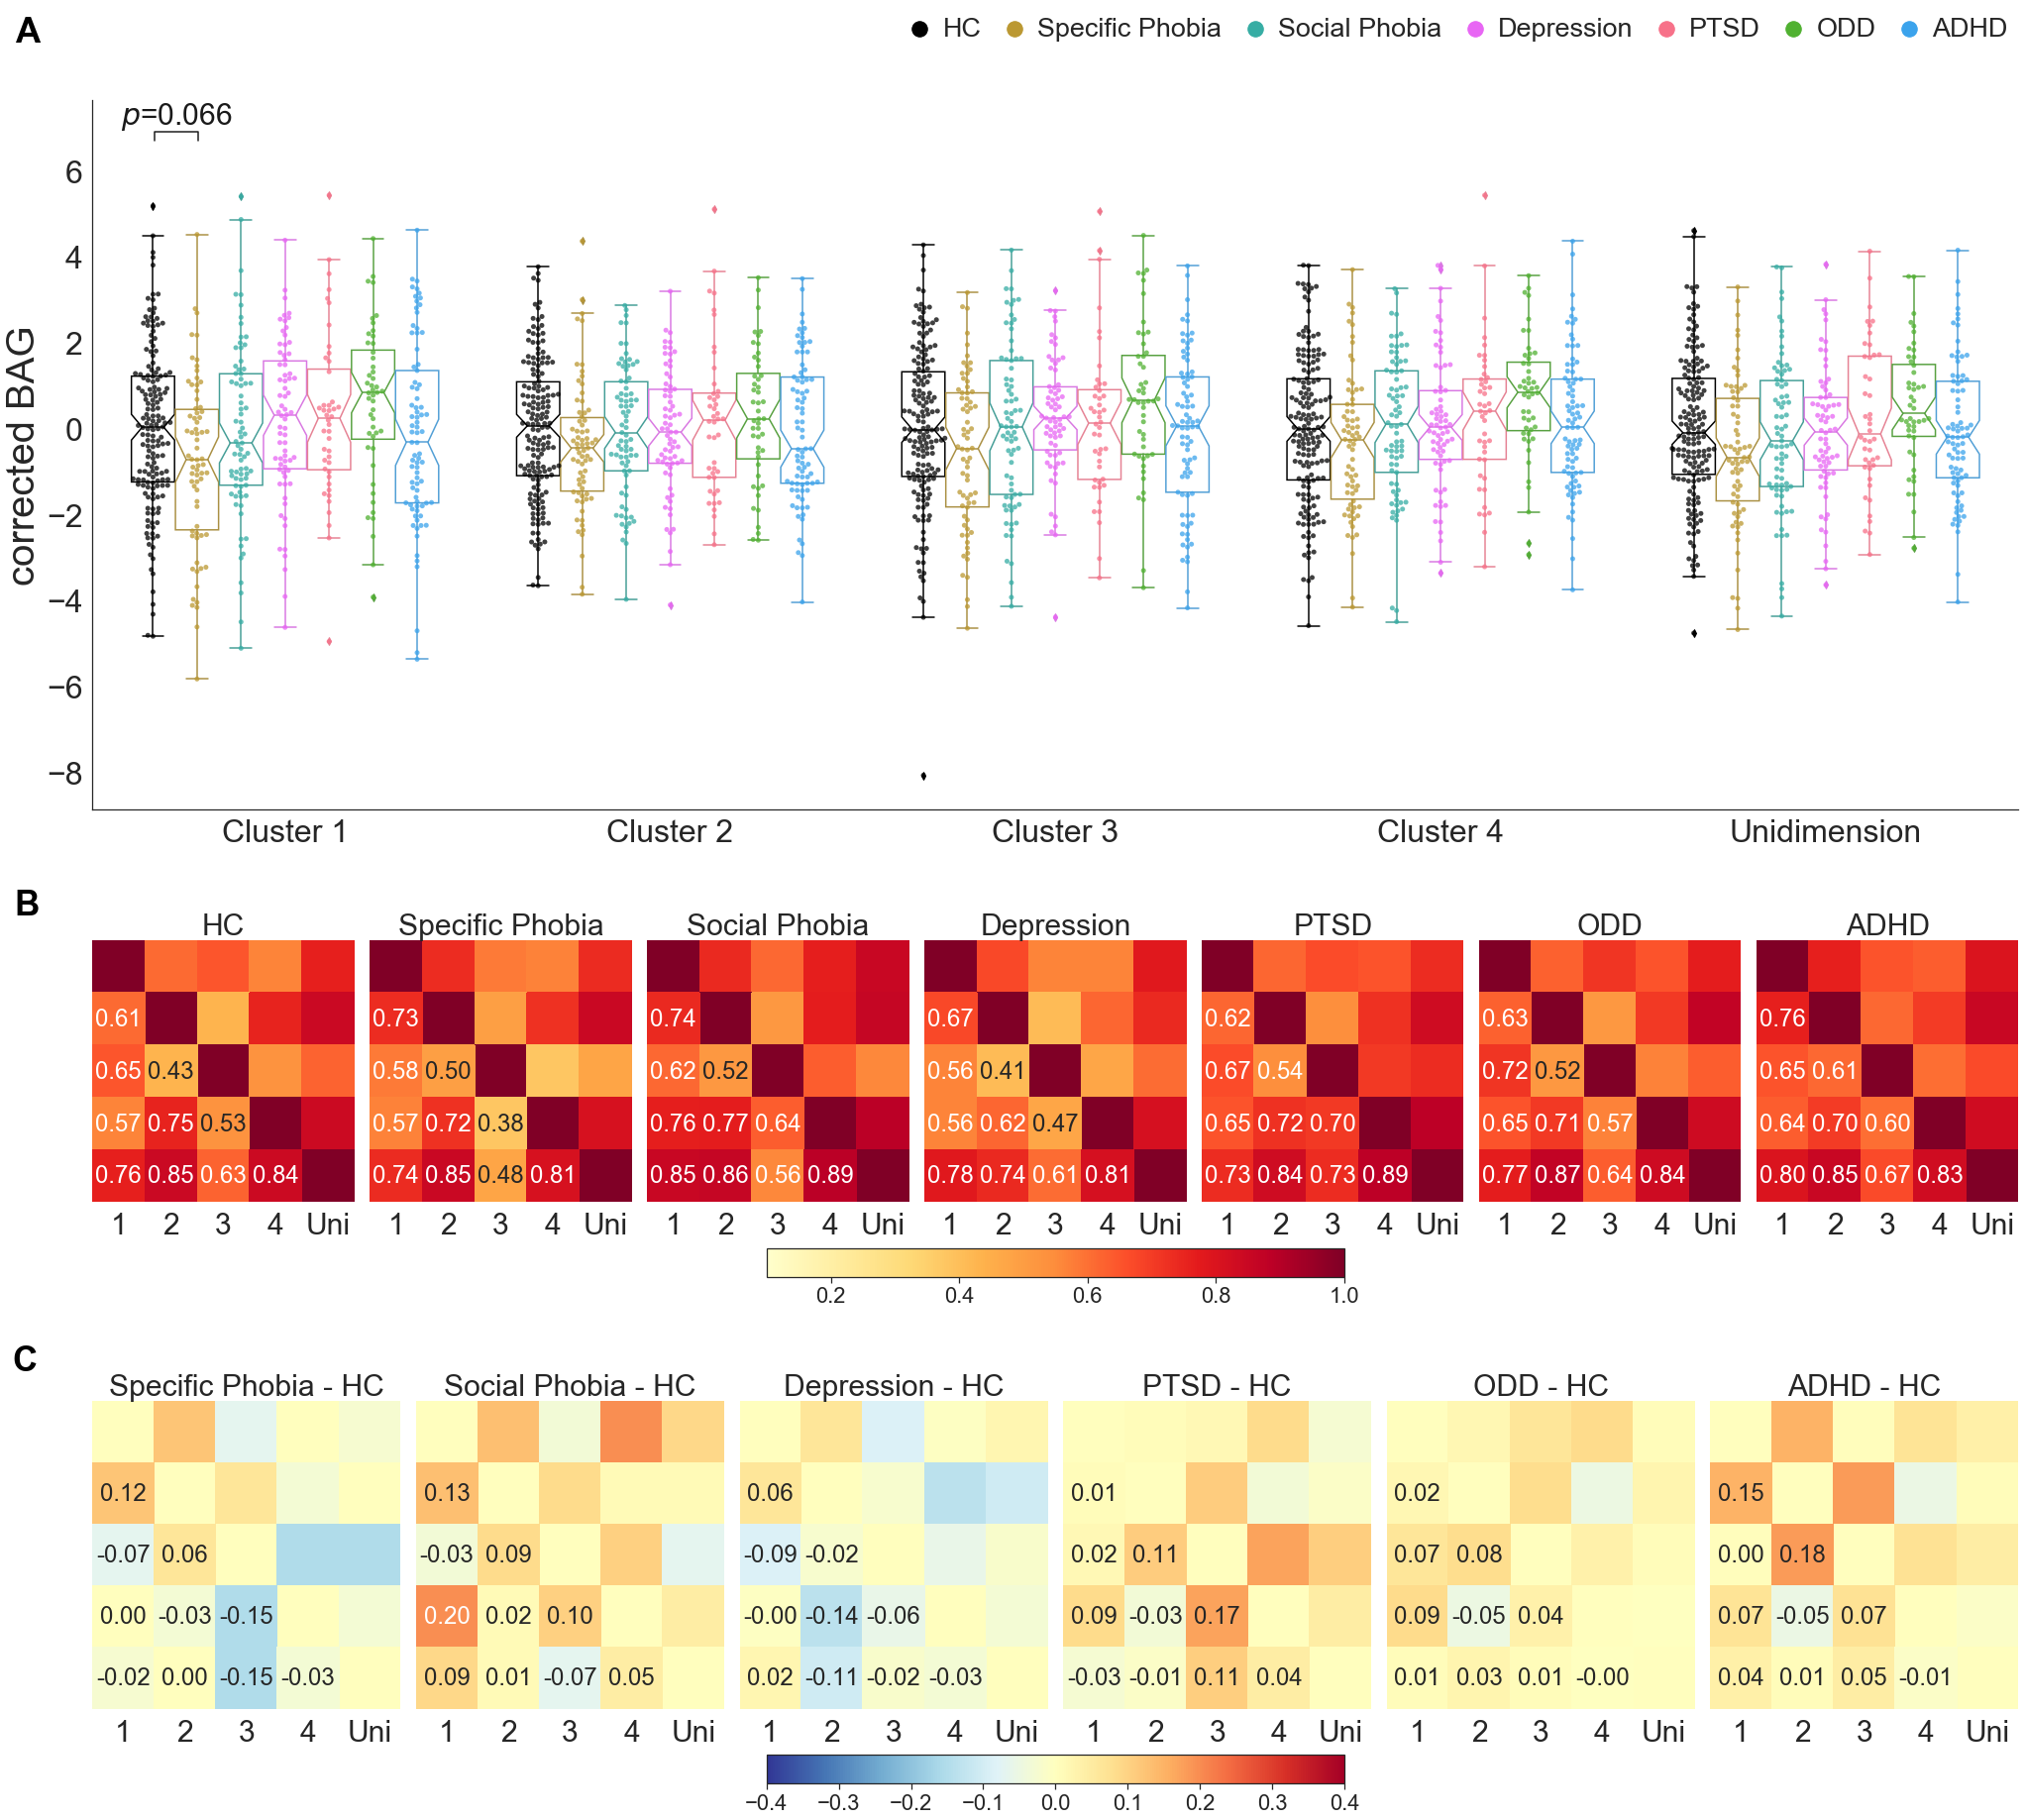

In [36]:
permutation_report_corrected2 = permutation_report.copy()
permutation_report_corrected2.iloc[[0,2,5],:] = permutation_report_corrected
permutation_report_corrected2.iloc[[1,3,4],:] = 1

f = box_heatmap_plot(scatter_data, permutation_report_corrected2, p_thresh = .1)
f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_corrected' + method + '_disorder025_'+ model + '.png', dpi=300,
          bbox_inches = 'tight', pad_inches = 0.5)

In [37]:
scatter_data



index cluster        SUBJID      CV  chronological age  brain age Sex  \
0         0     4.0  600009963128 1.00000            9.00000   11.08926   F   
547      49     1.0  609173350200 1.00000           12.00000   10.82656   M   
548      50     1.0  609259470422 1.00000           10.00000   12.92021   F   
549      51     1.0  609262364081 1.00000           13.00000   14.86803   F   
550      52     1.0  609652761759 1.00000           19.00000   16.67636   F   
...     ...     ...           ...     ...                ...        ...  ..   
3098    618     3.0  606855754171     nan           16.00000   17.40769   M   
3092    593     3.0  606673058004     nan           17.00000   15.86301   M   
3090    587     3.0  606531042603     nan           17.00000   15.63570   F   
3087    573     3.0  606304691757     nan           21.00000   14.80029   M   
3081    546     3.0  606109358844     nan           14.00000   15.91232   M   

     group  brain age fit intersex  age gap  age gap corr group2   cluster2  
0       HC                11.30976  2.08926      -0.22050     HC  cluster 4  
547     HC                13.52442 -1.17344      -2.69785     HC  cluster 1  
548     HC                12.59664  2.92021       0.32357     HC  cluster 1  
549     HC                13.96174  1.86803       0.90629     HC  cluster 1  
550     HC                16.23629 -2.32364       0.44007     HC  cluster 1  
...    ...                     ...      ...           ...    ...        ...  
3098   ODD                14.93002  1.40769       2.47768    ODD  cluster 3  
3092   ODD                15.26001 -1.13699       0.60300    ODD  cluster 3  
3090   ODD                15.77436 -1.36430      -0.13866    ODD  cluster 3  
3087   ODD                16.45794 -6.19971      -1.65765    ODD  cluster 3  
3081   ODD                14.23343  1.91232       1.67890    ODD  cluster 3  

[2780 rows x 13 columns]

${p}$=0.066


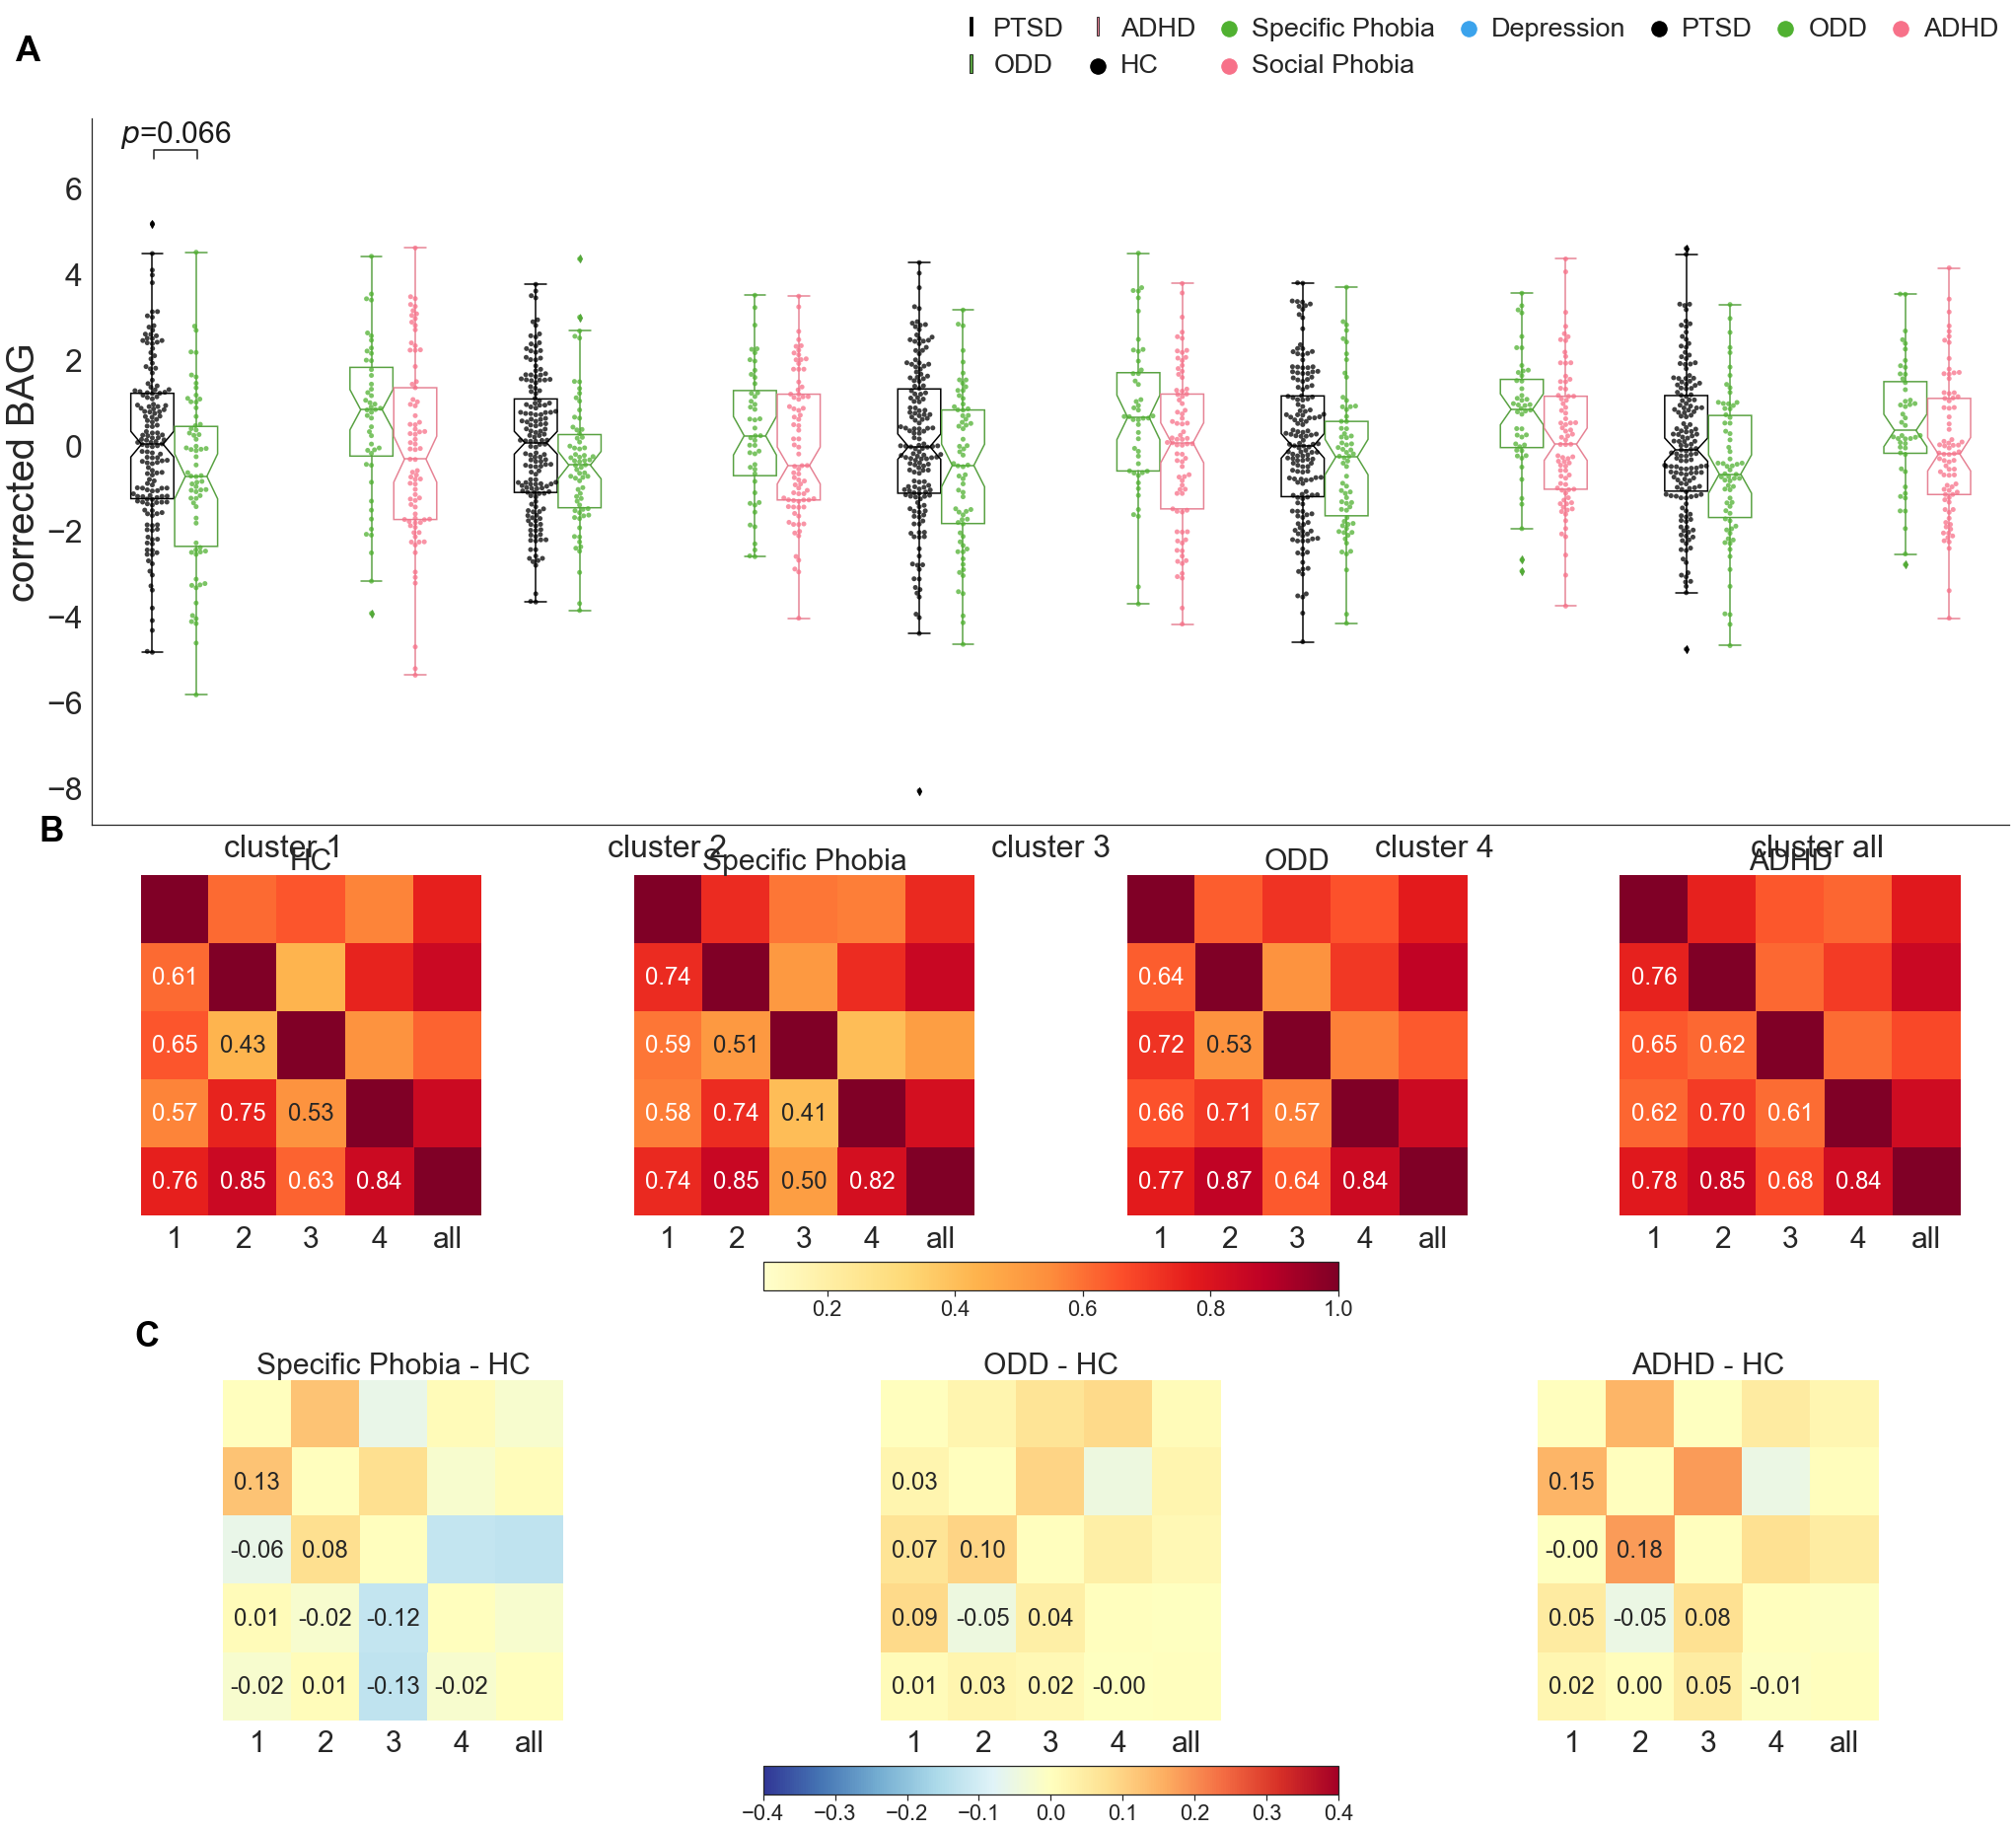

In [38]:
idx = scatter_data['group2'].isin(['HC', 'Specific Phobia', 'ODD', 'ADHD'])

scatter_data_drop = scatter_data[idx]

def box_heatmap_plot2(scatter_data, permutation_report, p_thresh = .07):
    
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(30, 32)}, font_scale = 2)
    sns.set_style("white")

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)
    group_label = list(scatter_data['group2'].unique().sort_values())
    num_group = len(group_label)

    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=7, ncols=num_group*(num_group-1), left=0.05, right=0.95, wspace=0.5, hspace = .25)
    
    ax1 = fig.add_subplot(gs[0:3, :])
    
    ax2_list = []
    gs_coord1 = range(0, num_group*(num_group-1), num_group-1)
    gs_coord2 = range(num_group-1, num_group*(num_group-1)+1, num_group-1)
    for i_subplot in range(num_group):
        ax2_list.append(fig.add_subplot(gs[3:5, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))
        
    ax3_list = []  
    gs_coord1 = range(0, num_group*(num_group-1), num_group)
    gs_coord2 = range(num_group, num_group*(num_group-1)+1, num_group)
    for i_subplot in range(num_group-1):
        ax3_list.append(fig.add_subplot(gs[5:, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))

    ############ box plot: ###########################
    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data2, 
                  hue = 'group2', dodge=True, ax = ax1,
                  palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data2, hue = 'group2', palette = colors,
                notch = True, ax = ax1)

#     ax1.set(xlabel='', ylabel='BAG (with correction)')
    ax1.set_xlabel('')
    ax1.set_ylabel('corrected BAG', size = 40)
    ax1.tick_params(axis='x', labelsize=32)
    ax1.tick_params(axis='y', labelsize=32)
    #ax1.set_xticklabels(cluster_idx, size = 35)
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = ax1.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'right', columnspacing = 1.2,
                   frameon = False, markerscale =2, handlelength = .1,
                   prop = {'size': 27}, title = '', bbox_to_anchor=(1, 1.1), ncol=7)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color, size = 30)


    y_base = np.array([1]*num_cluster)*6.7

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    ax1.text(-.7, 9, "A", horizontalalignment='left', size=35, color='black', weight='bold')
    
    ############################# heat map #################################
    
    idx = 0
    idx2= 0
    for i_group in group_label:
        
        scatter_data_group = scatter_data2.loc[scatter_data2['group2']==i_group,['SUBJID', 'cluster2', 'BAG']]
        scatter_data_group = scatter_data_group.pivot(index='SUBJID', columns='cluster2', values='BAG')
        matrix = scatter_data_group.corr()
        

        ## panel B:
        cmap_b = 'YlOrRd'
        # draw upper triangular heat map without annotation:
        im = sns.heatmap(matrix, annot=False, ax = ax2_list[idx], 
                         cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        # draw lower triangular heat map with annotation:
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        im = sns.heatmap(matrix, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                         ax = ax2_list[idx], cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        
        ax2_list[idx].set_ylabel("")
        ax2_list[idx].set_yticklabels("")
        ax2_list[idx].set_title(i_group, size = 30)
        ax2_list[idx].set_xlabel('')
        ax2_list[idx].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)

        cmap_c = 'RdYlBu_r'
        ## panel C:
        if idx==0:
            matrix_hc = matrix
        else:
            # draw upper triangular heat map without annotation:
            im2 = sns.heatmap(matrix-matrix_hc, annot=False, ax = ax3_list[idx2], 
                         cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)
            # draw lower triangular heat map with annotation:
            mask = np.triu(np.ones_like(matrix, dtype=np.bool))
            im2 = sns.heatmap(matrix-matrix_hc, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                             ax = ax3_list[idx2], cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)

            ax3_list[idx2].set_ylabel("")
            ax3_list[idx2].set_yticklabels("")
            ax3_list[idx2].set_title(i_group+ ' - HC', size = 30)
            ax3_list[idx2].set_xlabel('')
            ax3_list[idx2].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)
            
            idx2+=1
        
        idx+=1
            
    
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax = ax2_list, shrink = .3, location="bottom", pad = .1,)
    
    mappable = im2.get_children()[0]
    plt.colorbar(mappable, ax = ax3_list, shrink = .3, location="bottom", pad = .1,)
    
    ax2_list[0].text(-1.5, -.5, "B", horizontalalignment='left', size=35, color='black', weight='bold')
    ax3_list[0].text(-1.3, -.5, "C", horizontalalignment='left', size=35, color='black', weight='bold')
    
    #plt.tight_layout()
    plt.show()
    return(fig)

f = box_heatmap_plot2(scatter_data_drop, permutation_report_corrected, p_thresh = .1)
f.savefig(output_dir+'/figure4_boxplot_age_gap_025' + method + '_disorder_'+ model +'_' + correction_method + '.png', dpi=300)

In [39]:
scatter_data2['cluster2'].unique().sort_values()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


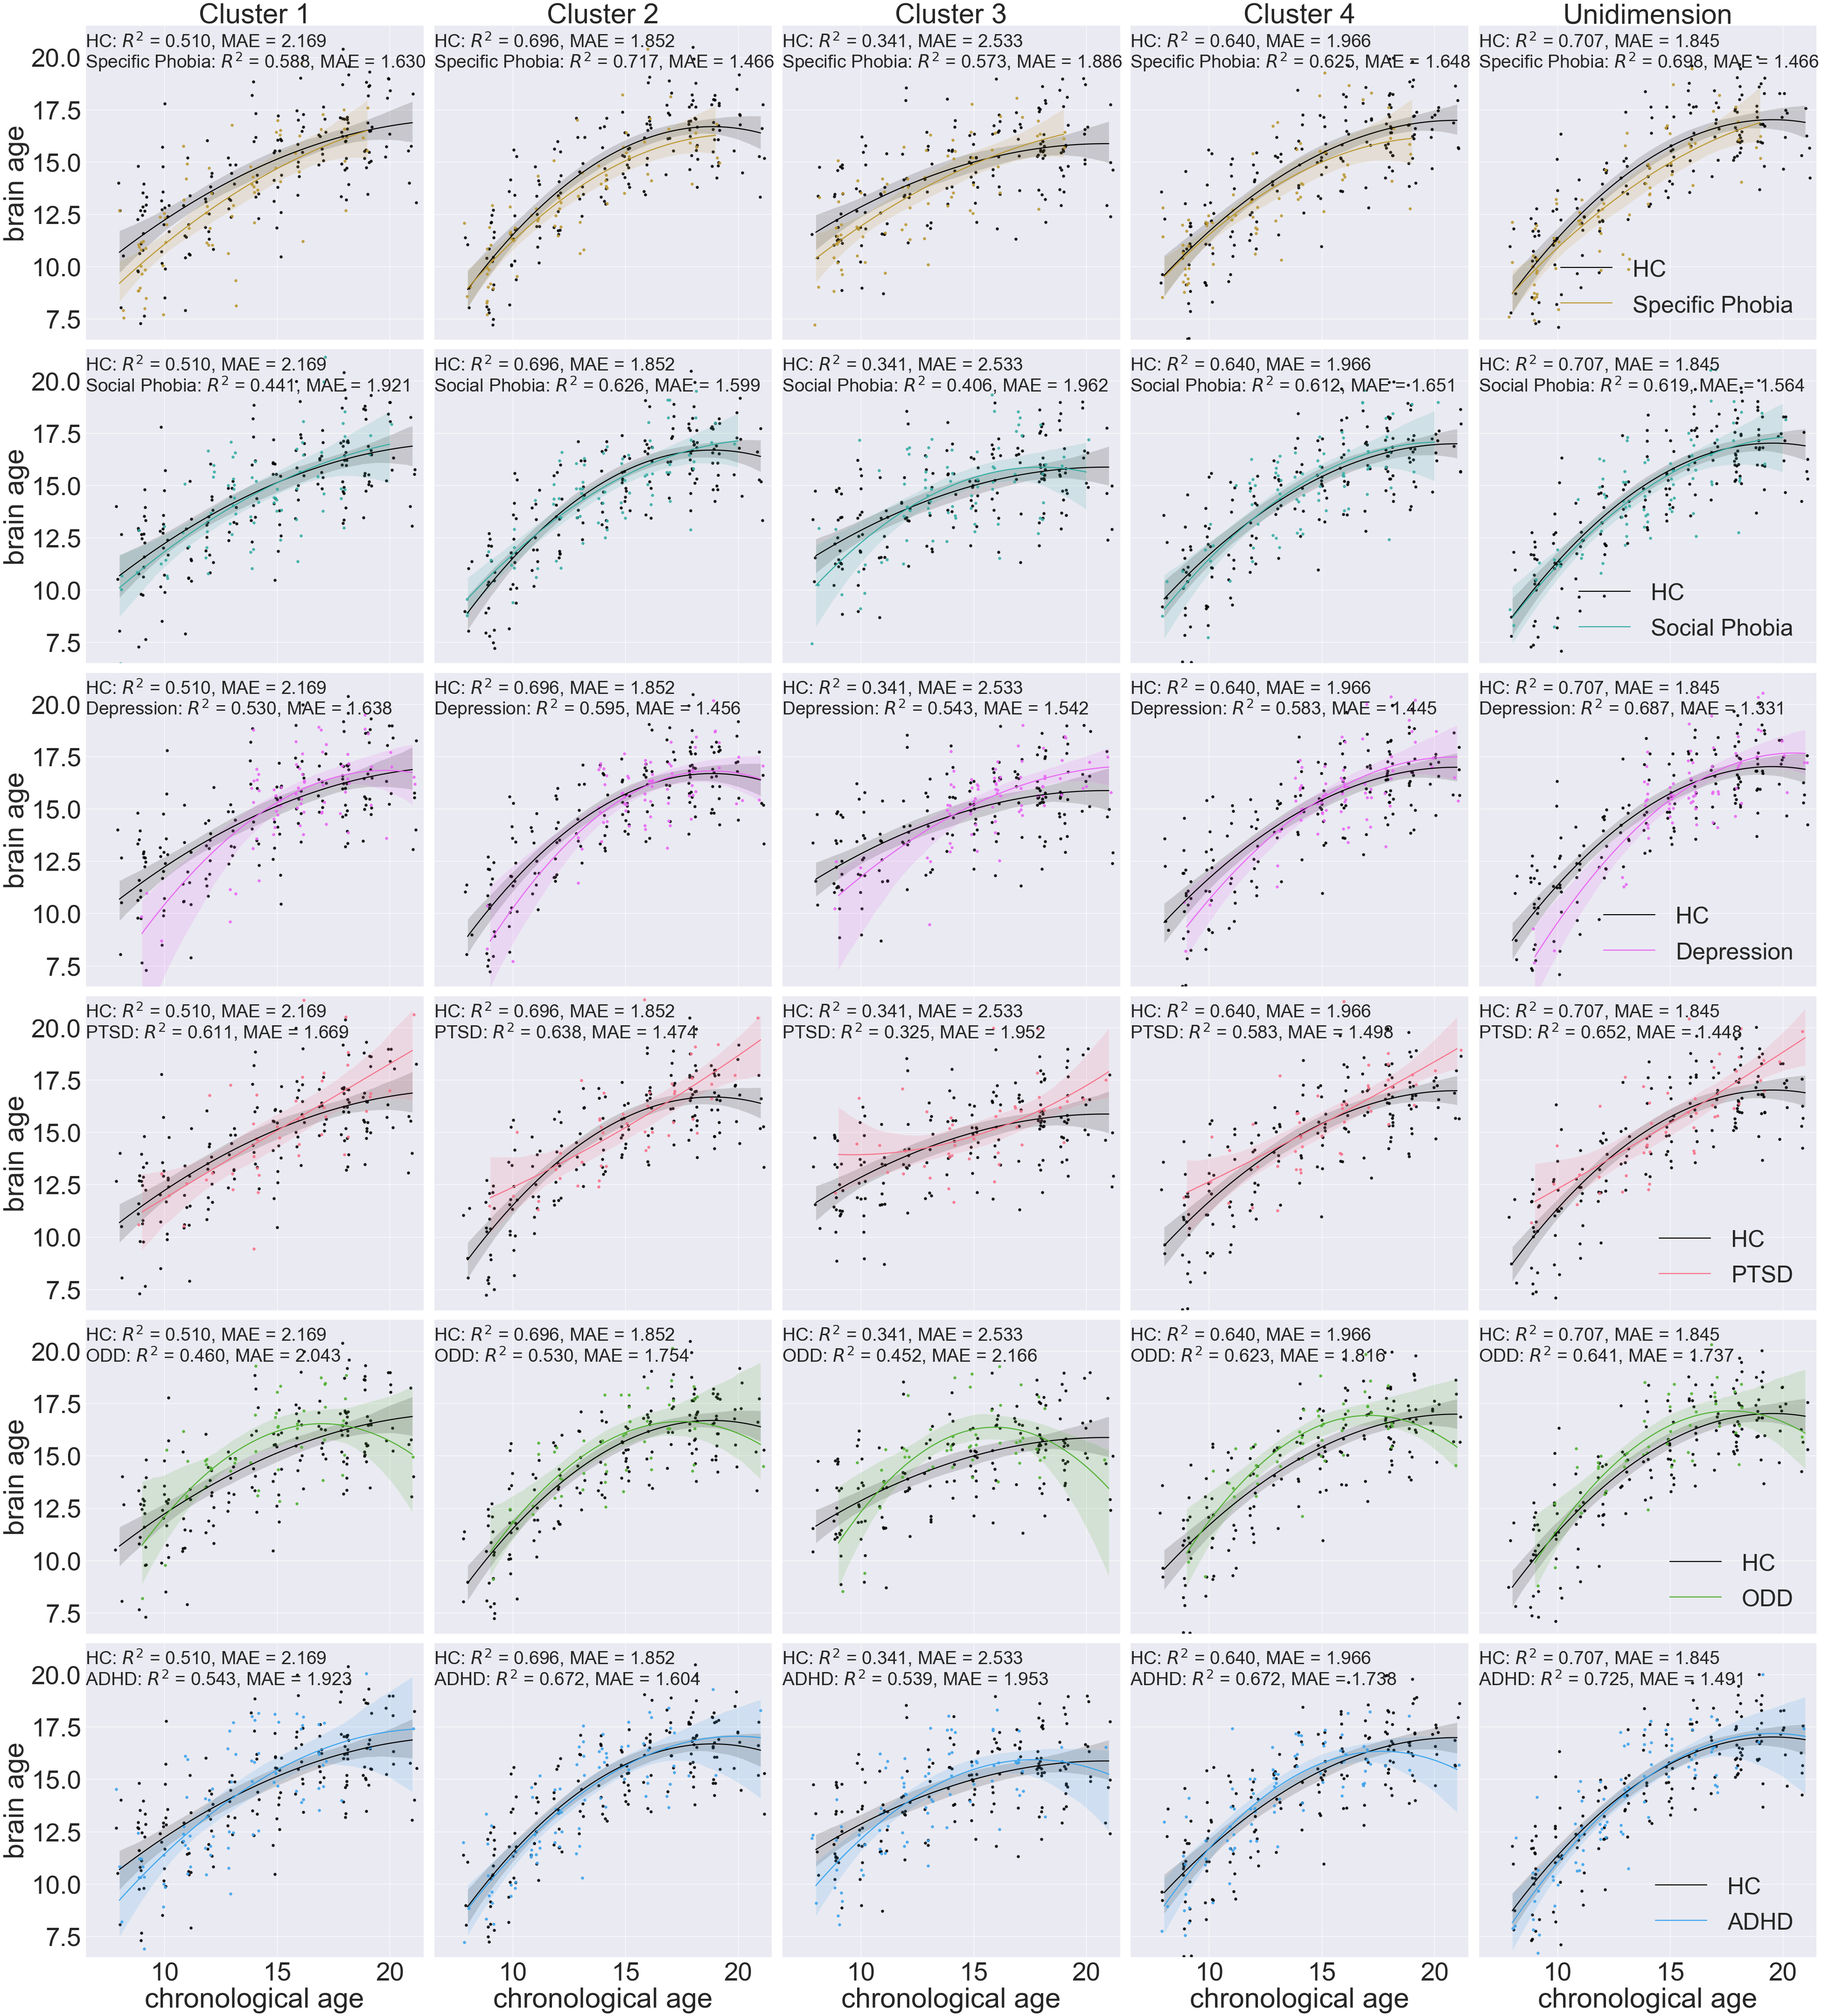

In [40]:
sns.set(rc={'figure.figsize':(6, 5.2)}, font_scale = 5)
text_size = 45

group_label = ['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Depression', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Social anxiety', 'ODD', 'ADHD']

# colors = sns.color_palette("RdBu_r", 7)
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
colors = colors[::2] + colors[1::2] 

scatter_para = {'alpha': 0.9, 's': 40, 'linewidth': 0.15}

def plot_result_disorder(plot_data, group_label):

    plot_data['plot_row'] = 1
    column_title = plot_data['cluster2'].unique().sort_values()
    num_cluster = len(plot_data['cluster2'].unique())-1
    column_title2 = ['Cluster ' + str(n) for n in range(1, num_cluster+1)] + ['Unidimension']
    
    plot_data_list = []
    for i in range(1, len(group_label)):
        plot_data_i = plot_data[plot_data['group'].isin([group_label[0]]+[group_label[i]])]
        plot_data_i.loc[:,'plot_row'] = i
        plot_data_list.append(plot_data_i)
        
    plot_data_merge = pd.concat(plot_data_list, axis = 0)
    
#     cluster_name = plot_data['cluster'].unique()
#     variable_name = plot_data['group'].unique()

    g = sns.lmplot(x='chronological age', y='brain age', hue = 'group', 
                   col = 'cluster2', row = 'plot_row', palette = colors, 
                   data = plot_data_merge, fit_reg=True, sharex = True, sharey = True, \
                   scatter_kws=scatter_para, x_jitter = .2, order = 2,\
                   height=10.27, aspect=9.17/8.27, legend = False)

    g.axes[0,0].set_xlim(6.5, 21.5)
    g.axes[0,0].set_ylim(6.5, 21.5)

    # comment this to check if column labels are correct:
    for col in range(len(column_title2)):
        g.axes[0, col].set_title(column_title2[col])
        for row in range(1,len(group_label)-1):
            g.axes[row, col].set_title('')
    
#     plt.setp(g._legend.get_title(), fontsize=45)
#     g._legend.set_title('')
#     for lh in g._legend.legendHandles[:2]: 
#         lh.set_alpha(1)
#         lh._sizes = [200] 
    
    # add legend for each row:
    for row in range(len(group_label)-1):
        g.axes[row, -1].legend(['HC', group_label[row+1]], loc = 'lower right',frameon=False)
        plt.setp(g.axes[row, -1].get_legend().get_texts(), fontsize='50')
            
    # compute R squared for each group and cluster:
    for col in range(len(column_title)):
        chro_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                 'chronological age'].values
        brain_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                  'brain age'].values
        gender = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                               'Sex'].map({'F':0, 'M':1}).values
        
        label_hc = "HC: $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender), 
                                                     np.mean(np.abs(chro_age - brain_age)))
        
        for row in range(len(group_label)-1):
            chro_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                     'chronological age'].values
            brain_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                      'brain age'].values
            gender = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                   'Sex'].map({'F':0, 'M':1}).values
            
            label_dis = group_label[row+1]+ ": $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender),
                                                                            np.mean(np.abs(chro_age - brain_age)))
            
            g.axes[row, col].text(6.5, 20.5, label_hc, fontsize = 39)
            g.axes[row, col].text(6.5, 19.5, label_dis, fontsize = 39)
        
    plt.subplots_adjust(hspace=0.03, wspace=0.03)


plot_result_disorder(scatter_data, group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_' + method + 'disorder' + model + '.png', dpi=300)

C:\Users\Xin\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Xin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Xin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:80

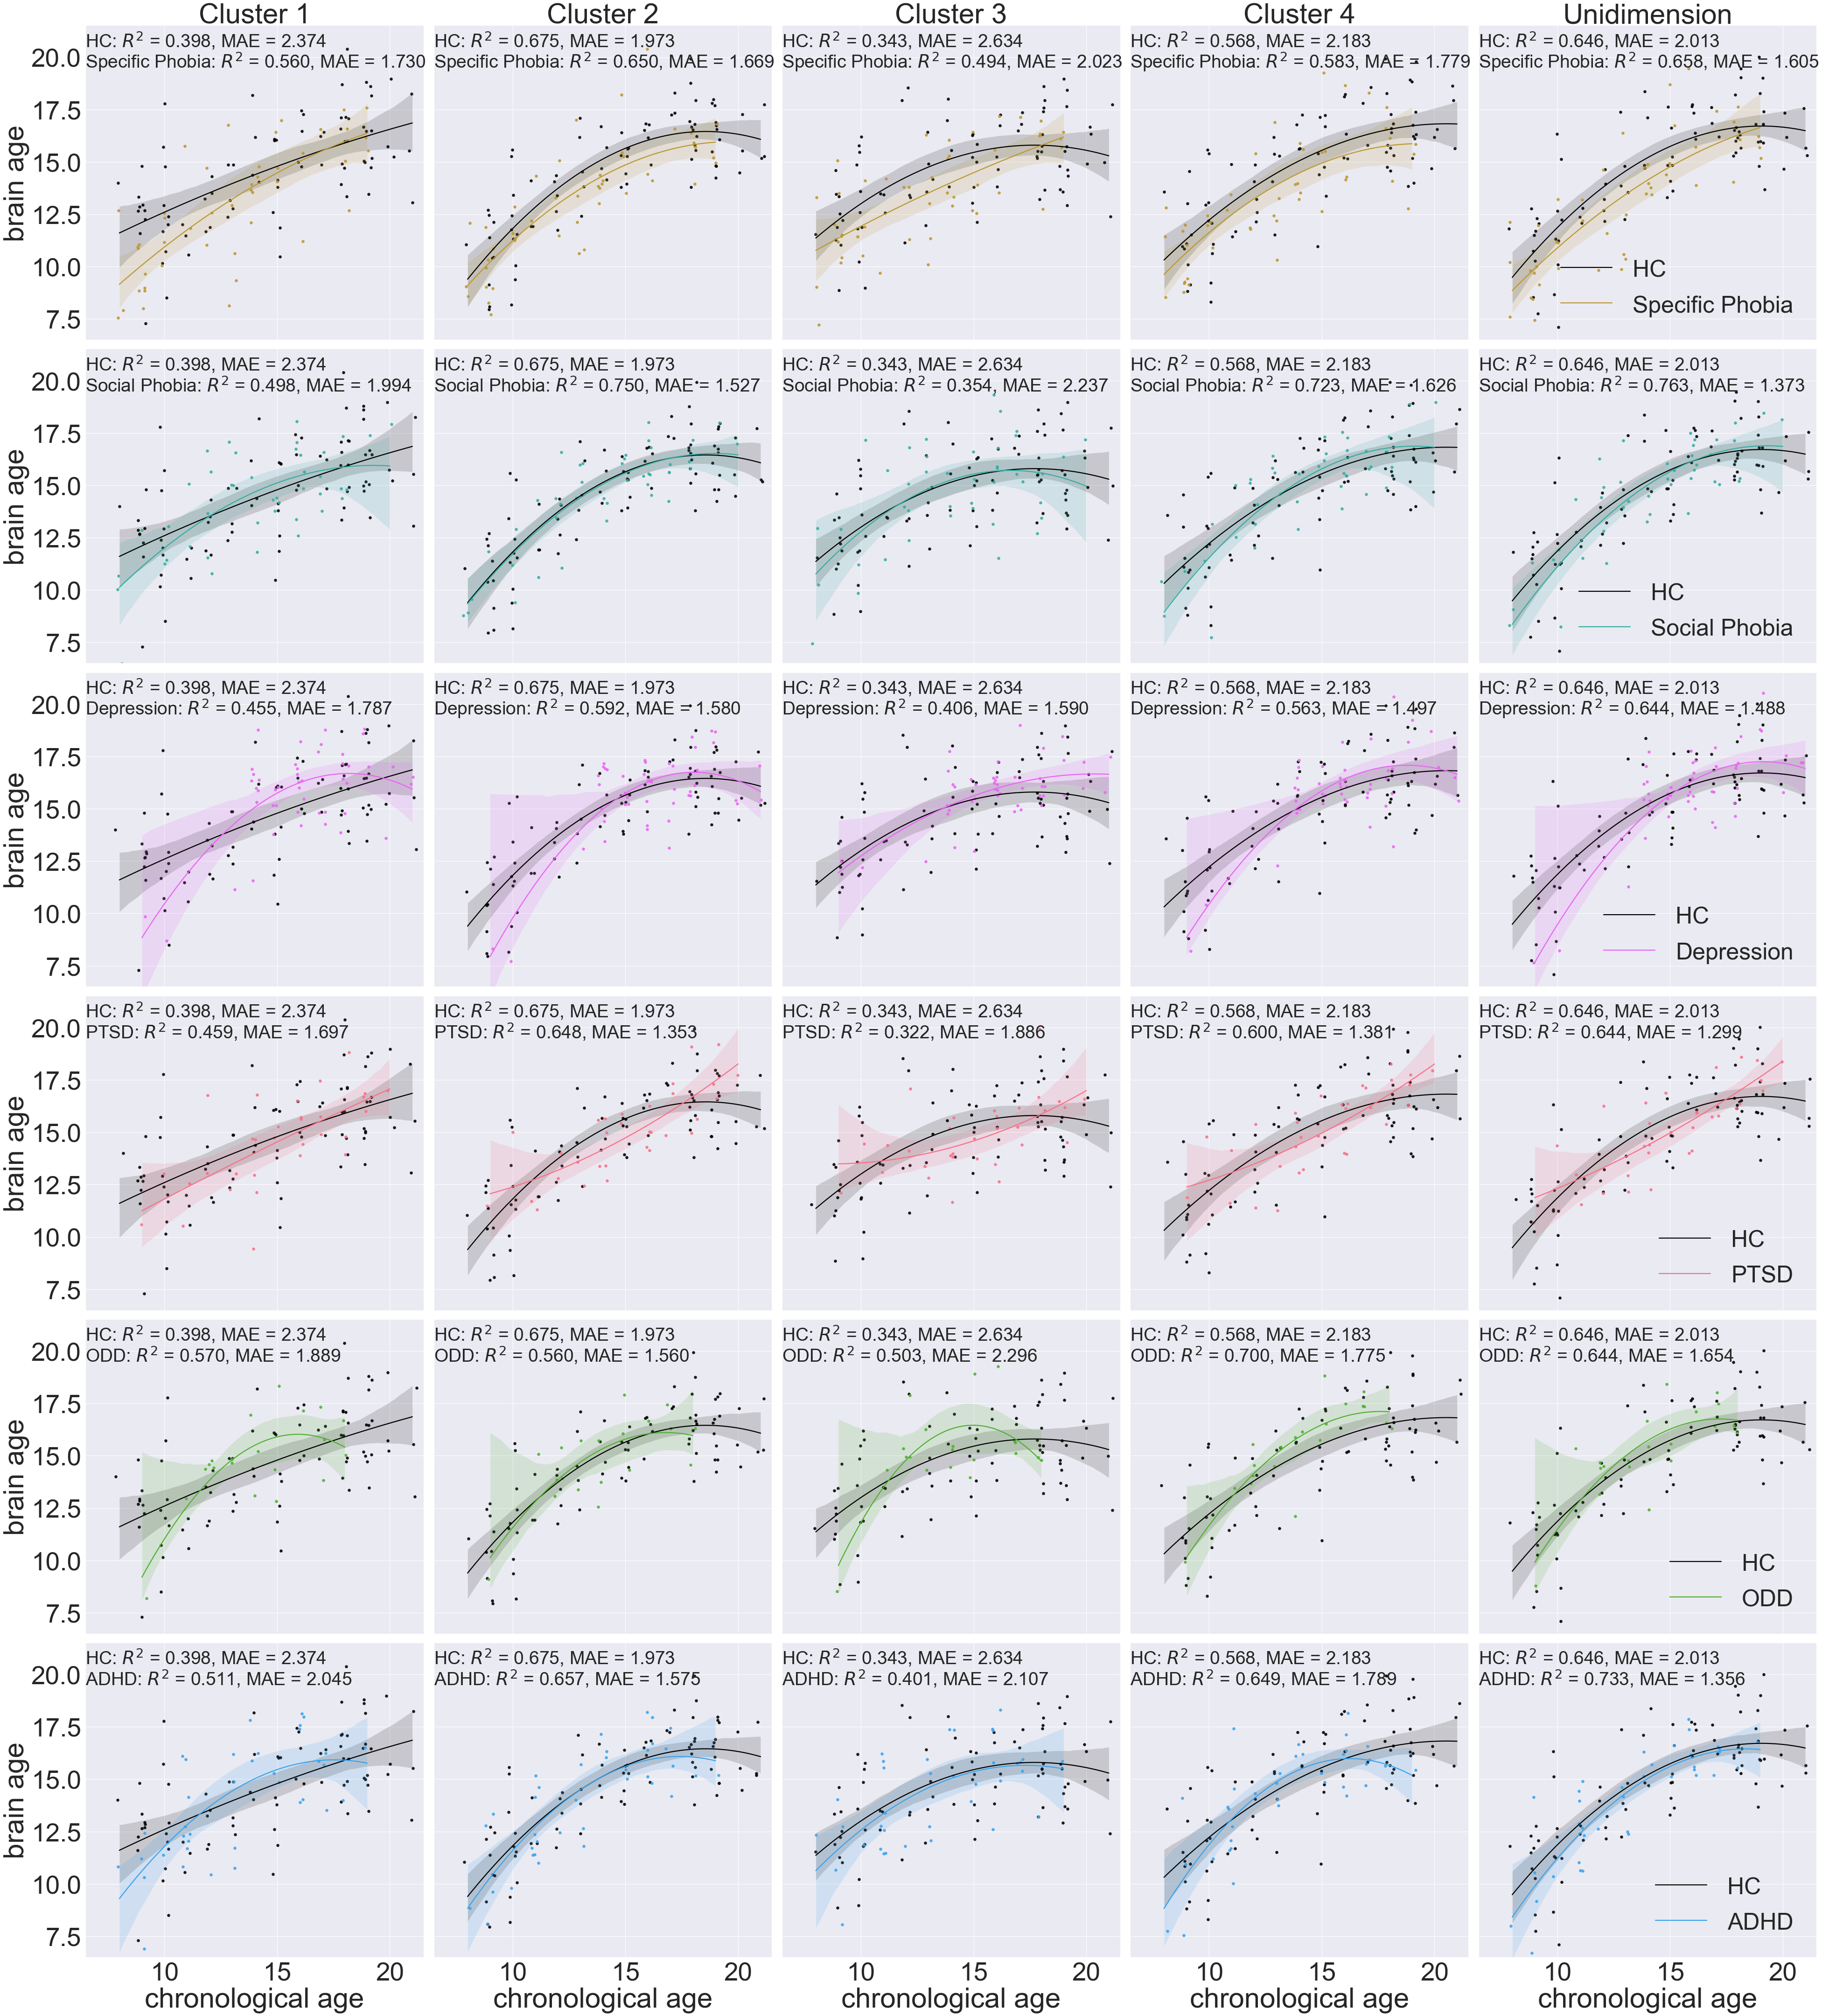

In [41]:
plot_result_disorder(scatter_data.loc[scatter_data['Sex']=='F',:], group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_female_' + method + 'disorder' + model + '.png', dpi=300)

C:\Users\Xin\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


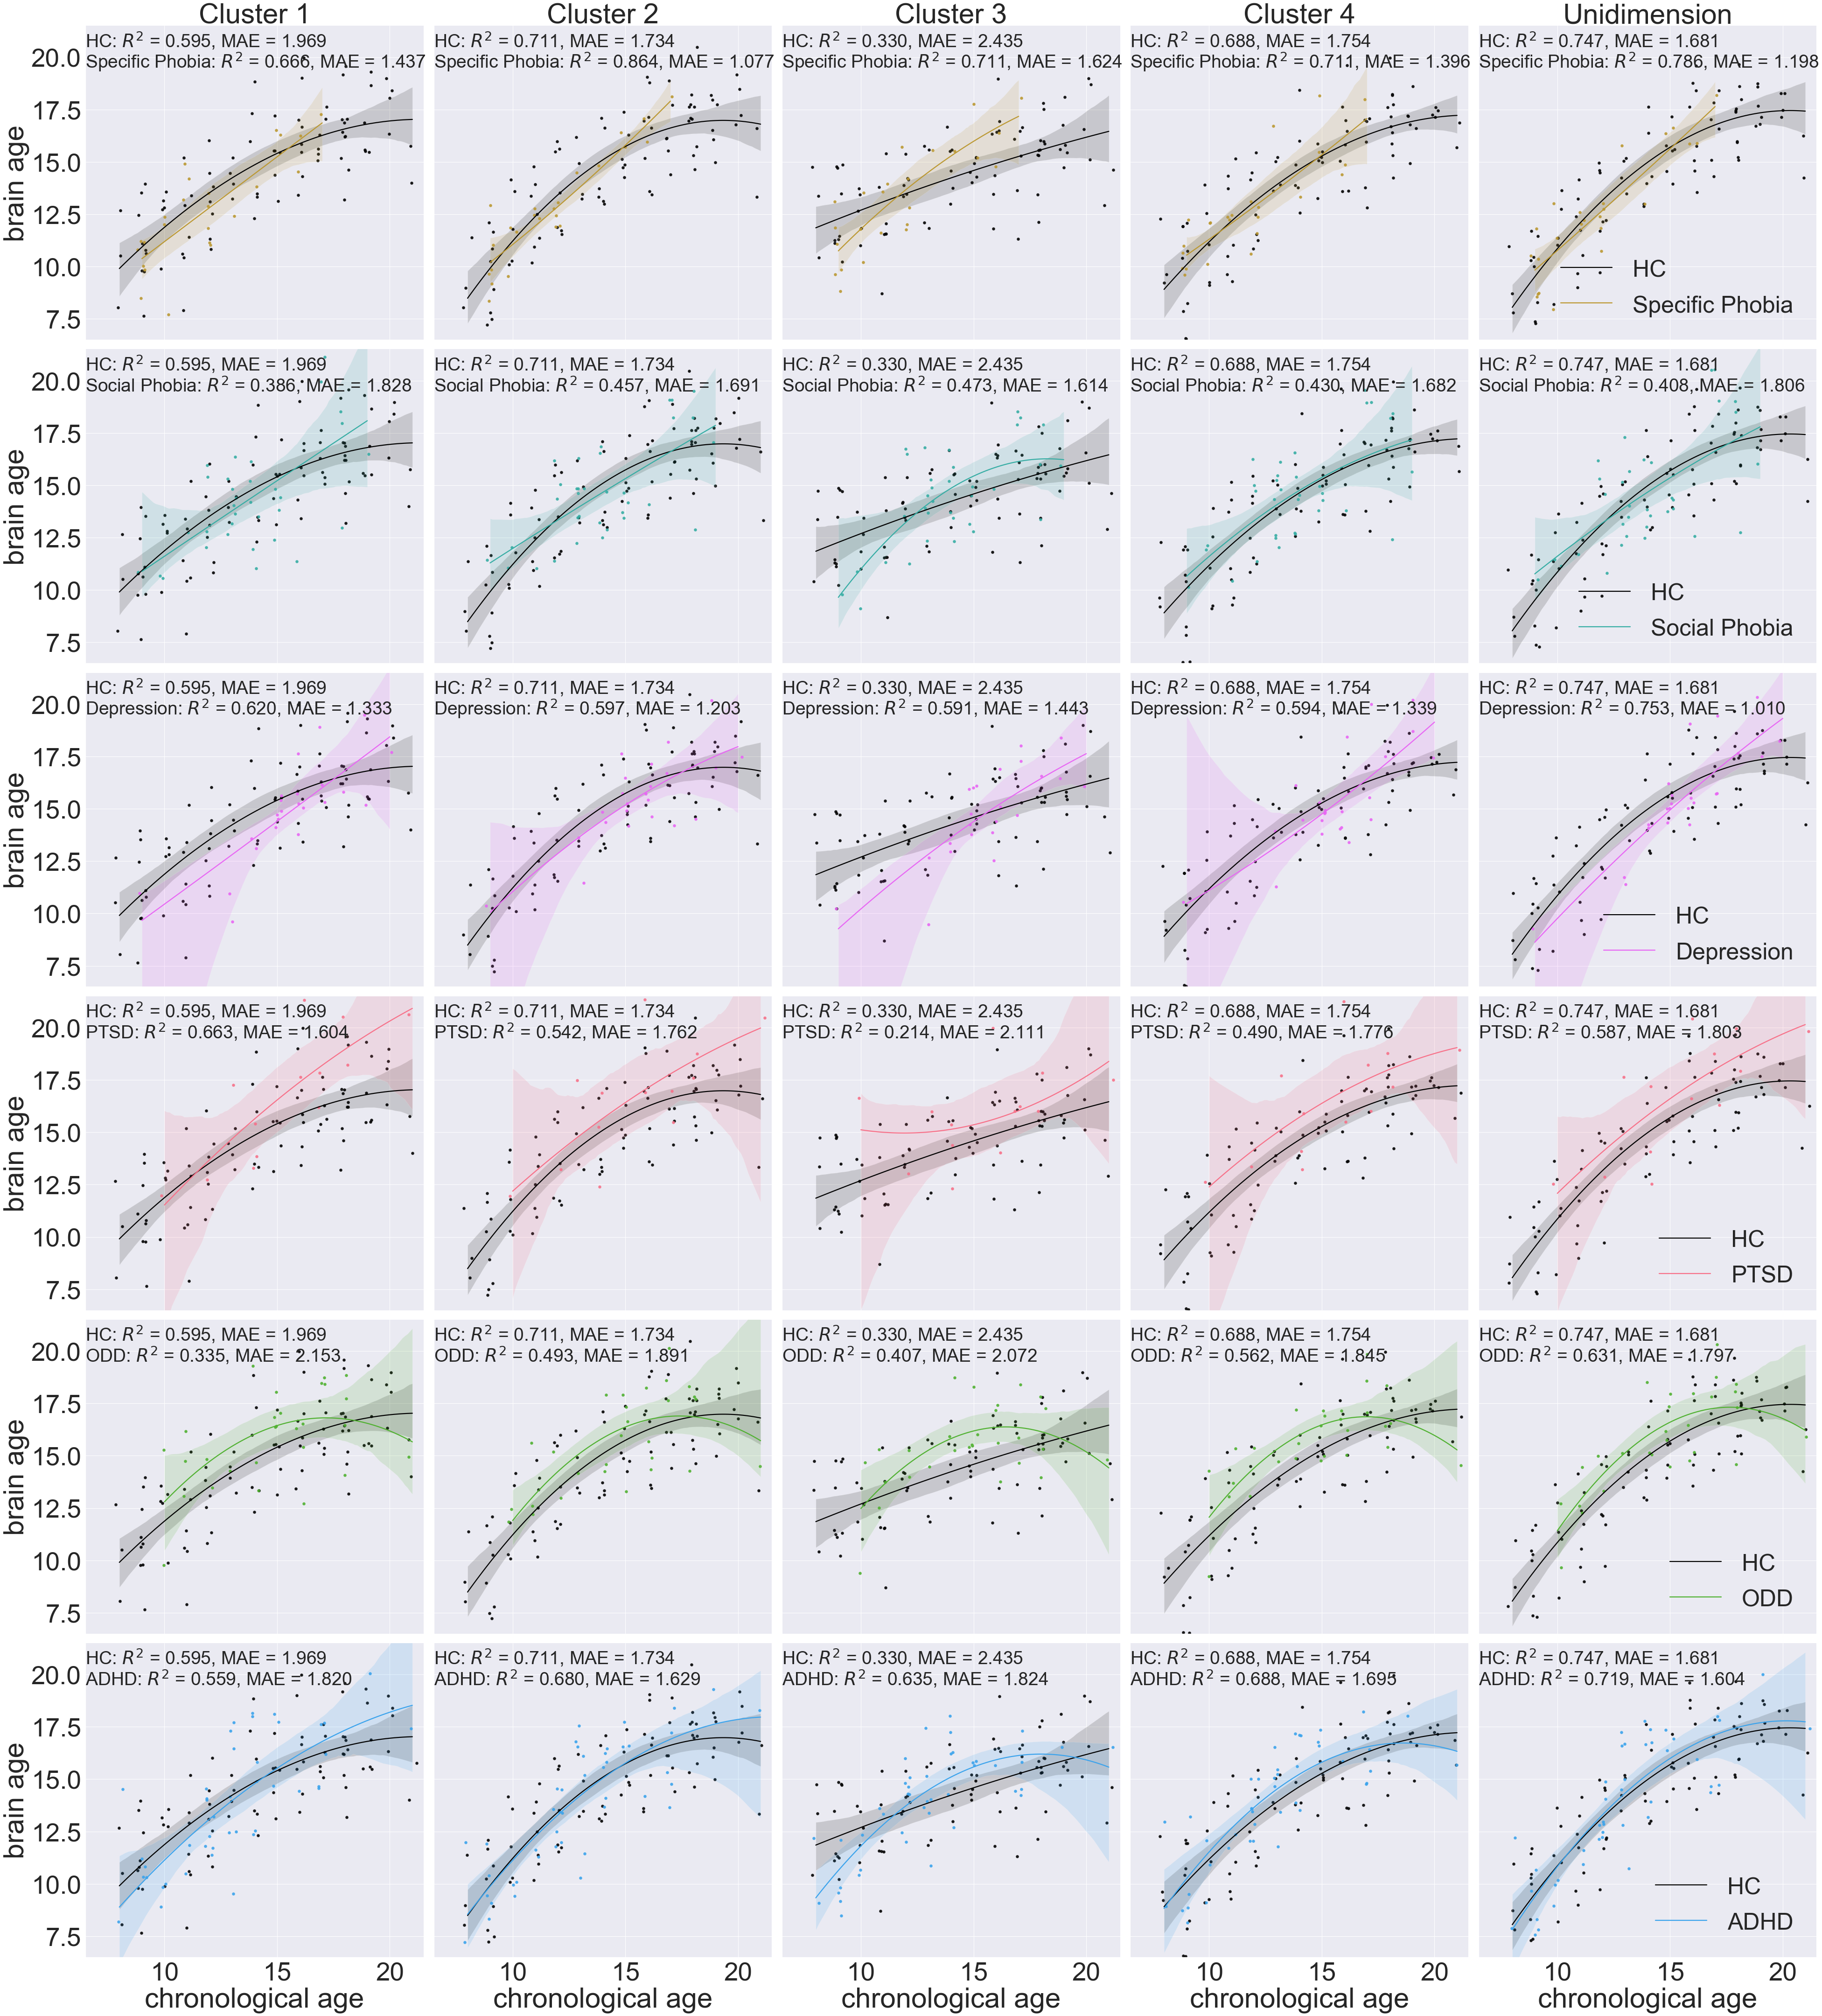

In [42]:
plot_result_disorder(scatter_data.loc[scatter_data['Sex']=='M',:], group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_male_' + method + 'disorder' + model + '.png', dpi=300)